In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten, UpSampling2D, LeakyReLU, Dense, Input, add
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Suppress TensorFlow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
# Define a residual block for the generator
def res_block(ip):
    # First convolutional layer
    res_model = Conv2D(64, (3, 3), padding="same")(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1, 2])(res_model)
    
    # Second convolutional layer
    res_model = Conv2D(64, (3, 3), padding="same")(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    
    # Skip connection: add input to processed tensor
    return add([ip, res_model])

# Define an upscale block for the generator
def upscale_block(ip):
    # Convolutional layer
    up_model = Conv2D(256, (3, 3), padding="same")(ip)
    # Upsampling
    up_model = UpSampling2D(size=2)(up_model)
    # Activation function
    up_model = PReLU(shared_axes=[1, 2])(up_model)
    
    return up_model


In [3]:
# Generator model creation function
def create_gen(gen_ip, num_res_block):
    # Initial convolutional layer
    layers = Conv2D(64, (9, 9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1, 2])(layers)

    # Store the initial tensor for the skip connection
    temp = layers

    # Add residual blocks
    for i in range(num_res_block):
        layers = res_block(layers)

    # Additional convolutional layer before the skip connection
    layers = Conv2D(64, (3, 3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers, temp])  # Skip connection

    # Upscaling blocks
    layers = upscale_block(layers)
    layers = upscale_block(layers)

    # Final convolutional layer for output
    op = Conv2D(3, (9, 9), padding="same")(layers)  # 3 filters for RGB channels

    # Create and return the generator model
    return Model(inputs=gen_ip, outputs=op)


In [4]:
def discriminator_block(ip, filters, strides=1, bn=True):
    # Convolutional layer
    disc_model = Conv2D(filters, (3, 3), strides=strides, padding="same")(ip)
    
    # Batch normalization
    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)
    
    # Leaky ReLU activation
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    
    return disc_model

In [5]:
def create_disc(disc_ip):
    # Number of filters
    df = 64
    
    # Stack discriminator blocks
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    # Flatten the feature maps
    d8_5 = Flatten()(d8)
    
    # Fully connected layers
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    
    # Output layer (sigmoid activation for binary classification)
    validity = Dense(1, activation='sigmoid')(d10)

    # Create and return the discriminator model
    return Model(disc_ip, validity)


In [6]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    # Load pre-trained VGG19 model
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    
    # Create a new Model that outputs feature maps from the 11th layer of VGG19
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [7]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    # Generate high-resolution image from low-resolution input
    gen_img = gen_model(lr_ip)
    
    # Extract features from the generated high-resolution image
    gen_features = vgg(gen_img)
    
    # Set discriminator model as non-trainable
    disc_model.trainable = False
    
    # Predict the validity (real or fake) of the generated high-resolution image
    validity = disc_model(gen_img)
    
    # Create and return the combined model
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


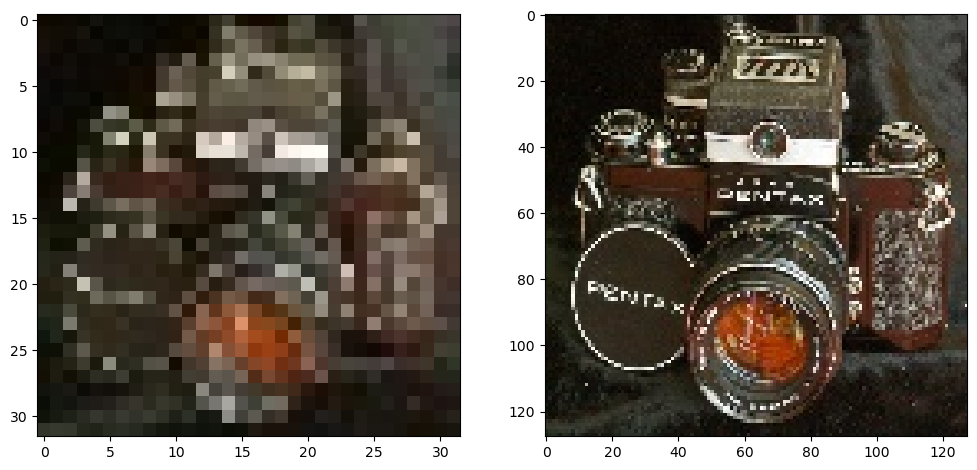

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_5[0][0]']           
                                                                                                  
 batch_normalization_9 (Bat  (None, 32, 32, 64)           256       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 add_4 (Add)                 (None, 32, 32, 64)           0         ['add_3[0][0]',               
                                                                     'batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_11

 p_re_lu_10 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_10[0][0]']          
                                                                                                  
 batch_normalization_19 (Ba  (None, 32, 32, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_9 (Add)                 (None, 32, 32, 64)           0         ['add_8[0][0]',               
                                                                     'batch_normalization_19[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_15 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_15[0][0]']          
                                                                                                  
 batch_normalization_29 (Ba  (None, 32, 32, 64)           256       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_14 (A

                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_37 (Ba  (None, 16, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 512)       1180160   
                                                                 
 batch_normalization_38 (Ba  (None, 16, 16, 512)       2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_44

In [8]:
#For demo purposes, let us use 5000 images
n=200
lr_list = os.listdir("lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    


In [9]:
epochs = 150

# Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1))  # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size, 1))   # Assign a label of 1 to all real images.
    
    # Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []
    
    # Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]  # Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b]  # Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs)  # Fake images
        
        # First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        # Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        # Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        # Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        # Train the generator via GAN.
        # Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        # Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    # Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    # Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    # Report the progress during training.
    print("epoch:", e+1, "g_loss:", g_loss, "d_loss:", d_loss)


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▌                                                                                 | 1/134 [00:21<48:39, 21.95s/it]

1/1 [==============================] - 0s 64ms/step


  1%|█▏                                                                                | 2/134 [00:23<21:46,  9.90s/it]

1/1 [==============================] - 0s 59ms/step


  2%|█▊                                                                                | 3/134 [00:24<13:11,  6.04s/it]

1/1 [==============================] - 0s 64ms/step


  3%|██▍                                                                               | 4/134 [00:26<09:09,  4.23s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:27<06:56,  3.23s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:29<05:38,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:30<04:44,  2.24s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:32<04:11,  2.00s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:33<03:47,  1.82s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:34<03:28,  1.68s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:36<03:15,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:37<03:05,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:39<02:59,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:40<02:54,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:41<02:50,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:43<02:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:44<02:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:46<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:47<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:48<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:50<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:51<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:53<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:54<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:55<02:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:57<02:31,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:58<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [01:00<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [01:01<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [01:02<02:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [01:04<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [01:05<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [01:06<02:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [01:08<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [01:09<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [01:11<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [01:12<02:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:13<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:15<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:16<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:18<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:19<02:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:20<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:22<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:23<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:25<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:26<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:27<01:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:29<02:00,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:30<02:01,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:32<01:58,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:33<01:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:35<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:36<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:37<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:39<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:40<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:41<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:43<01:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:44<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:46<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:47<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:48<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:50<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:51<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:53<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:54<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:55<01:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:57<01:30,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:58<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:59<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [02:01<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [02:02<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [02:04<01:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [02:05<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:06<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:08<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:09<01:19,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:11<01:18,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:12<01:17,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:14<01:16,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:15<01:15,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:17<01:13,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:18<01:11,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:19<01:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:21<01:07,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:22<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:23<01:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:25<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:26<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:28<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:29<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:30<00:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:32<00:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:33<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:34<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:36<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:37<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:39<00:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:40<00:47,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:46,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:43<00:44,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:43,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:46<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:40,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:02<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:05<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:06<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:08<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:09<00:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:11<00:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:12<00:15,  1.39s/it]

1/1 [==============================] - 0s 56ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:13<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:15<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:16<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:17<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:19<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:20<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:22<00:05,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:23<00:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:24<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:26<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:27<00:00,  1.55s/it]


epoch: 1 g_loss: 142.29984935361946 d_loss: [7.16396503 0.73507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 2 g_loss: 109.13990116119385 d_loss: [2.37874627 0.8358209 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<03:00,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:43,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:47,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:47,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:47,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:47,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:44,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:43,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:41,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▉                                                                | 28/134 [00:40<02:41,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:41,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:43<02:40,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:38,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:46<02:36,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:34,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:49<02:34,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:51<02:32,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:52<02:31,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:54<02:29,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:55<02:27,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:57<02:24,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:58<02:23,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:00<02:22,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:01<02:21,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:03<02:19,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:04<02:18,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:06<02:16,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:07<02:15,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:09<02:14,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:10<02:11,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:12<02:09,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:13<02:07,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:15<02:05,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:16<02:03,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:18<02:01,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:19<02:00,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:21<01:58,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:23<01:57,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:24<01:56,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:26<01:54,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:27<01:53,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:29<01:53,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:30<01:50,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:32<01:48,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:33<01:47,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:35<01:45,  1.51s/it]

1/1 [==============================] - 0s 76ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:36<01:43,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:38<01:40,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:39<01:39,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:40<01:36,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:42<01:36,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:43<01:34,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:45<01:32,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:46<01:32,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:48<01:30,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:49<01:28,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:51<01:26,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:52<01:25,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:54<01:24,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:55<01:22,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:57<01:22,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:58<01:19,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:00<01:17,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:01<01:15,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:02<01:12,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:04<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:05<01:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:07<01:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:08<01:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:09<01:04,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:11<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:12<01:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:14<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:15<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:16<00:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:18<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:19<00:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:20<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:22<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:23<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:25<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:26<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:27<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:29<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:30<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:31<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:33<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:34<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:36<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:37<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:38<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:40<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:41<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:43<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:44<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:45<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:47<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:48<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:49<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:51<00:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:52<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:54<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:55<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:56<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:58<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:59<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:01<00:12,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:02<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:03<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:05<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:06<00:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:08<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:09<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:10<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:12<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:13<00:00,  1.44s/it]


epoch: 3 g_loss: 89.43760682575738 d_loss: [1.17019466 0.87686567]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:18,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:17,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:14,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:13,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:10,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.37s/it]

1/1 [==============================] - 0s 94ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:07,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 4 g_loss: 78.1468984831625 d_loss: [1.63626048 0.85447761]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:17,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:14,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:15,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:12,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:09,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:07,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:08,  1.48s/it]

1/1 [==============================] - 0s 94ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:09,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:13<03:06,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<03:04,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:16<03:02,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:17<03:01,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:19<02:59,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:58,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:22<02:58,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:23<02:55,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:25<02:54,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:26<02:54,  1.50s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████▍                                                                     | 19/134 [00:28<02:53,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 15%|████████████                                                                     | 20/134 [00:29<02:53,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:31<02:49,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:32<02:46,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:34<02:44,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:35<02:42,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:37<02:40,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:38<02:38,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:40<02:37,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:41<02:34,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:42<02:32,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:44<02:32,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:45<02:30,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:47<02:29,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:48<02:27,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:50<02:26,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:51<02:24,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:53<02:20,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:54<02:19,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:56<02:18,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:57<02:19,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:59<02:18,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:00<02:16,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:01<02:15,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:03<02:14,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:04<02:11,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:06<02:08,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:07<02:07,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:09<02:06,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:10<02:04,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:12<02:04,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:13<02:01,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:14<01:59,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:16<01:58,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:17<01:57,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:19<01:55,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:20<01:53,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:22<01:52,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:23<01:50,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:25<01:49,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:26<01:47,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:27<01:46,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:29<01:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:30<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:32<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:33<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:34<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:36<01:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:37<01:32,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:39<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:40<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:41<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:43<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:44<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:45<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:47<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:48<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:50<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:51<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:52<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:54<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:55<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:56<01:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:58<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:59<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:01<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:02<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:03<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:05<01:04,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:06<01:02,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:07<01:01,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:09<00:59,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:10<00:58,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:11<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:13<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:14<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:16<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:17<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:18<00:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:20<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:21<00:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:22<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:24<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:25<00:43,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:27<00:42,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:28<00:40,  1.36s/it]

1/1 [==============================] - 0s 61ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:29<00:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:31<00:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:32<00:36,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:33<00:35,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:35<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:36<00:32,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:37<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:39<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:40<00:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:42<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:43<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:44<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:46<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:47<00:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:48<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:50<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:51<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:53<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:54<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:55<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:57<00:12,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:58<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:59<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:01<00:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:02<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:04<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:05<00:04,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:06<00:02,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:08<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:09<00:00,  1.41s/it]


epoch: 5 g_loss: 71.05234379554862 d_loss: [1.39732419 0.79850746]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:17,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:47<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:13,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:12,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:10,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:09,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:08,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:58<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:02,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:09<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:57,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:50,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:50,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:48,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:47,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:47,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:41,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:10,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:03,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 6 g_loss: 67.19512013535001 d_loss: [1.35948652 0.83955224]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:40,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:18,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:10,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:09,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:07,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:58<02:05,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:57,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:09<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:16<01:46,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:20<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:31<01:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:42<01:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:46<01:16,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:49<01:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:53<01:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:57<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:00<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:04<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:08<00:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:11<00:51,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:15<00:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:19<00:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:22<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:26<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:30<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:33<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:37<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:41<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:44<00:19,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:45<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:48<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:52<00:10,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:55<00:08,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:56<00:06,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [02:59<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:03<00:00,  1.37s/it]


epoch: 7 g_loss: 63.37026128484242 d_loss: [1.06511967 0.85820896]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<02:58,  1.34s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<02:58,  1.35s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:55,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:30,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:13,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:11,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:16<01:46,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:18,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:11<00:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:22<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:33<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:44<00:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:55<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.37s/it]


epoch: 8 g_loss: 61.3258357475053 d_loss: [1.14462918 0.84701493]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:33,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:31,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:30,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:36<02:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:24,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:47<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:09,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:07,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:58<02:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:09<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:16<01:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:20<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:31<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:25,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:49<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 9 g_loss: 59.5431983150653 d_loss: [0.86872038 0.8880597 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 61ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:25,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:24,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:08,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:16<01:46,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:44,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:20<01:41,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:39,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:29,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:18,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:17,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:52,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:51,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 10 g_loss: 58.479748868230566 d_loss: [1.51671052 0.7761194 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:30,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:28,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:25,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:04,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:03,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<02:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:59,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:10,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:46,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 11 g_loss: 59.296326530513475 d_loss: [0.67193206 0.87686567]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:32,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:30,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:29,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:28,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:25,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:49<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:53<01:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:00<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:04<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:11<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:15<00:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:44,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:22<00:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:26<00:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:30<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:33<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:37<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:44<00:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:48<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:52<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:55<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [02:59<00:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:03<00:00,  1.37s/it]


epoch: 12 g_loss: 56.325507932634494 d_loss: [0.92234761 0.8358209 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:32,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:43,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:56,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 13 g_loss: 56.257110851914135 d_loss: [0.77170781 0.88059701]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:21,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:20,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:02,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 14 g_loss: 54.03420925852078 d_loss: [2.18817235 0.77238806]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:26,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 15 g_loss: 52.843831169071485 d_loss: [1.11791976 0.83208955]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:51,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:47,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:45,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:21,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:19,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:21,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:21,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:20,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:18,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:25,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:21,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:14,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 16 g_loss: 52.21182241012801 d_loss: [0.75829092 0.88059701]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<02:59,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:52,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:51,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:51,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 17 g_loss: 51.9010327182599 d_loss: [0.66750498 0.8880597 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:38,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:33,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:29,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:26,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:23,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:57,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:33,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:30,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:28,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:24,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:23,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:22,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:20,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:17,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:13,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:10,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:59,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:58,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:55,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:50,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:50,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:48,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:46,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:45,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:43,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:42,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:40,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:39,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:37,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:36,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:34,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:33,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:30,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:27,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:26,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:24,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:23,  1.45s/it]

1/1 [==============================] - 0s 82ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:20,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:19,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:17,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:16,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:14,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:56<00:13,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:59<00:10,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:00<00:08,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:07,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:03<00:05,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:06<00:02,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:07<00:01,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:09<00:00,  1.41s/it]


epoch: 18 g_loss: 49.18767111337007 d_loss: [0.43085839 0.92537313]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:07,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:03,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:59,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:58,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<02:55,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:45,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:44,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:44,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:43,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:41,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:39,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:38,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:37,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:36,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:34,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:34,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:31,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:29,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:28,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:27,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:26,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:24,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:21,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:19,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:16,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:16,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:57<02:14,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:15,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:00<02:17,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:16,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:03<02:14,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:04<02:13,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:06<02:10,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:07<02:09,  1.49s/it]

1/1 [==============================] - 0s 94ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:09<02:09,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:10<02:09,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:12<02:09,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:13<02:06,  1.53s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:15<02:04,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:16<02:00,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:18<01:58,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:19<01:55,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:21<01:53,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:22<01:50,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:23<01:49,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:25<01:47,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:26<01:46,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:28<01:45,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:29<01:44,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:31<01:43,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:32<01:42,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:34<01:41,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:35<01:40,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:37<01:38,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:38<01:37,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:40<01:35,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:41<01:34,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:42<01:32,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:44<01:30,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:45<01:29,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:47<01:27,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:48<01:25,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:50<01:24,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:51<01:23,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:53<01:22,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:54<01:21,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:56<01:20,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:57<01:18,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:59<01:16,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:00<01:15,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:02<01:14,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:03<01:12,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:05<01:10,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:06<01:09,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:07<01:07,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:09<01:05,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:10<01:04,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:12<01:03,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:13<01:01,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:15<01:00,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:16<00:58,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:18<00:57,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:19<00:55,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:21<00:53,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:22<00:52,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:24<00:50,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:25<00:50,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:27<00:48,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:28<00:47,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:29<00:45,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:31<00:44,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:32<00:42,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:34<00:40,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:35<00:39,  1.47s/it]

1/1 [==============================] - 0s 94ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:37<00:38,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:38<00:36,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:40<00:35,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:41<00:33,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:43<00:32,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:44<00:30,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:46<00:29,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:47<00:27,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:48<00:26,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:50<00:24,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:51<00:23,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:53<00:22,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:54<00:20,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:56<00:19,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:57<00:17,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:59<00:16,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:00<00:15,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:02<00:13,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:03<00:12,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:05<00:10,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:06<00:09,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:08<00:07,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:09<00:06,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:11<00:04,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:12<00:02,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:14<00:01,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:15<00:00,  1.46s/it]


epoch: 19 g_loss: 47.41992786037388 d_loss: [0.79590595 0.87686567]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:19,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:12,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:11,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:10,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:07<03:07,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:09,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:09,  1.49s/it]

1/1 [==============================] - 0s 94ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:11,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:13<03:09,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<03:05,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:16<03:02,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:17<03:00,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:19<02:57,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:55,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:22<02:53,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:23<02:51,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:25<02:55,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:26<02:51,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:28<02:48,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:29<02:48,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:31<02:46,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:32<02:42,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:33<02:42,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:35<02:40,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:36<02:38,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:38<02:36,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:39<02:37,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:41<02:35,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:42<02:33,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:44<02:31,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:45<02:30,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:47<02:27,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:48<02:26,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:49<02:25,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:51<02:22,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:52<02:22,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:54<02:21,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:55<02:19,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:57<02:18,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:58<02:17,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:00<02:15,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:01<02:13,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:03<02:12,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:04<02:10,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:05<02:08,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:07<02:08,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:08<02:07,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:10<02:04,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:11<02:01,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:13<01:59,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:14<01:58,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:15<01:57,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:17<01:57,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:18<01:56,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:20<01:56,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:21<01:56,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:23<01:55,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:25<01:55,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:26<01:53,  1.52s/it]

1/1 [==============================] - 0s 94ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:28<01:54,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:29<01:55,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:31<01:53,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:33<01:53,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:34<01:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:36<01:50,  1.60s/it]

1/1 [==============================] - 0s 109ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:37<01:50,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:39<01:50,  1.65s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:41<01:49,  1.66s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:42<01:47,  1.65s/it]

1/1 [==============================] - 0s 94ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:44<01:45,  1.66s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:46<01:41,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:47<01:36,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:49<01:34,  1.55s/it]

1/1 [==============================] - 0s 94ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:50<01:34,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:52<01:34,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:53<01:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:55<01:28,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:57<01:28,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:58<01:25,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:59<01:21,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:01<01:18,  1.48s/it]

1/1 [==============================] - 0s 109ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:02<01:17,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:04<01:15,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:05<01:13,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:07<01:13,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:08<01:12,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:10<01:11,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:11<01:09,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:13<01:07,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:14<01:05,  1.50s/it]

1/1 [==============================] - 0s 94ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:16<01:04,  1.50s/it]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:17<01:03,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:19<01:01,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:20<00:58,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:22<00:55,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:23<00:53,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:24<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:26<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:27<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:28<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:30<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:31<00:43,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:33<00:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:34<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:35<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:37<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:38<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:40<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:41<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:42<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:44<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:45<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:46<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:48<00:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:49<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:51<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:52<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:53<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:55<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:56<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:57<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:59<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:00<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:02<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:03<00:12,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:04<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:06<00:09,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:07<00:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:08<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:10<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:11<00:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:13<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:14<00:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:15<00:00,  1.46s/it]


epoch: 20 g_loss: 45.63979554532179 d_loss: [2.65798988 0.71641791]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:09,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:06,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:04,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:07<03:00,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:38,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:12,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:57,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 21 g_loss: 44.866225356486304 d_loss: [0.73765673 0.88059701]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:41,  1.37s/it]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:09,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:17,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:49<01:13,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:10,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:07,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:06,  1.35s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:00<01:02,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:04<00:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:11<00:51,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:15<00:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:19<00:43,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:22<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:26<00:37,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:32,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:33<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:44<00:19,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:55<00:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [02:59<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.37s/it]


epoch: 22 g_loss: 43.49683237075806 d_loss: [0.88805975 0.85820896]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:19,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:06,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:16<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:23,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:19,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:16,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:22<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 23 g_loss: 42.999292871845306 d_loss: [0.69035167 0.85820896]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:28,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:58<02:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:09<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:16<01:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:36,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:35,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:33,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:31<01:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:42<01:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:49<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:53<01:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:00<01:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:04<00:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:08<00:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:11<00:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:15<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:18<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:22<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:38,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:29<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:33<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:44<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:07,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 24 g_loss: 45.05195970677618 d_loss: [0.59390367 0.89179104]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:55,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:07,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:05,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:03,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:40,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:36,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:14,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:13,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 25 g_loss: 41.373610973358154 d_loss: [0.82739438 0.87686567]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:29,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:36,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:25,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 26 g_loss: 38.95059643930464 d_loss: [0.32466332 0.93283582]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<02:58,  1.34s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:42,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:55,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 27 g_loss: 39.50775498062817 d_loss: [0.47492616 0.92910448]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:35,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:24,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:16,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:47<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:54<02:09,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:05<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:43,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:27<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:34<01:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:38<01:24,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:45<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:07,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.36s/it]

1/1 [==============================] - 0s 94ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:54,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:25,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 28 g_loss: 37.207074279215796 d_loss: [0.20929875 0.96268657]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:37,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:14,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:40,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:36,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 29 g_loss: 36.14274039197324 d_loss: [0.79998393 0.89925373]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:25,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:32,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:28,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:24,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:21,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 94ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:43,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:41,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:38,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:36,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:32,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:31,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 30 g_loss: 34.31395723570639 d_loss: [0.72053188 0.91791045]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:28,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:21,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:20,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 31 g_loss: 33.43117743819507 d_loss: [0.14897273 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:23,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:24,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:22,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 32 g_loss: 33.35642268764439 d_loss: [0.14891548 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:34,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:33,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:34,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:32,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:29,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 33 g_loss: 31.36023226780678 d_loss: [0.45862736 0.94029851]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:41,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:41,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:35,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<00:59,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:55,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:32,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:31,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 34 g_loss: 30.03856692385318 d_loss: [0.90828022 0.88059701]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:52,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:51,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:46,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:35,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:34,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:32,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 35 g_loss: 30.25544561556916 d_loss: [1.81267555 0.81343284]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:27,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:27,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:25,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:23,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:24,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 36 g_loss: 28.701578695382644 d_loss: [0.54778106 0.89925373]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:57,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:29,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:10,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:10,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:09,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:07,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:04,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 37 g_loss: 28.555727844807638 d_loss: [0.78074446 0.89179104]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:17,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:16,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:14,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:12,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:10,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 38 g_loss: 29.12819435347372 d_loss: [0.27440435 0.94776119]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:08,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:06,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:03,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:06,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:08,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:03,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 94ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:55,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 39 g_loss: 29.007276513683262 d_loss: [0.14452623 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:43<02:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:50<02:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:01<02:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:12<01:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:34,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:15,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:13,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:12,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:59,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:58,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:14,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 40 g_loss: 27.696235009093783 d_loss: [0.06820395 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<02:59,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:58,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:23,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:17,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:23<01:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:52<01:11,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:09,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:56<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:05,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [01:59<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:03<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:07<00:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:10<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:14<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:21<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:25<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:28<00:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:32<00:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:36<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:39<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:40<00:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:43<00:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:47<00:16,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:50<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:51<00:12,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:54<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:57<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:58<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:00<00:04,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:01<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:02<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:04<00:00,  1.38s/it]


epoch: 41 g_loss: 24.714966596062503 d_loss: [0.2209882  0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:36,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:35,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:32,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:29,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:28,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:36,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:30,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:26,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:23,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:21,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:51,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 42 g_loss: 22.876210376397886 d_loss: [0.62307671 0.93283582]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:46,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:46,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:47,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:45,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:40,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:12,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:33,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:31,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 43 g_loss: 25.500712747004496 d_loss: [0.52095073 0.95149254]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:34,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:35,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:33,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:30,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:28,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:26,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:03,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:30,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:24,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 44 g_loss: 34.695172409513106 d_loss: [0.59372605 0.93283582]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<02:59,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:58,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:17,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:37,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:37,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:36,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:36,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:35,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:33,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:30,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:27,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 45 g_loss: 25.355725800813133 d_loss: [0.6856031  0.93283582]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:40,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:41,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:39,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:04,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:35,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:34,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:31,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 46 g_loss: 21.762916963491868 d_loss: [0.14906568 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:19<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:30<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:24,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:41<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:10,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:10,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:09,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:07,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:05,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:02,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<01:00,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:40,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 47 g_loss: 20.574463655699546 d_loss: [0.04820778 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<02:59,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:57,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:53,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:52,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:51,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:37,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:37,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:47,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:53,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:31<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:35<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:42<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:46<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:07,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 48 g_loss: 20.296086069363266 d_loss: [0.47523527 0.94029851]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:56,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:08<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.38s/it]

1/1 [==============================] - 0s 94ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:48<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:55<01:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:06<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:13<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:17<00:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:24<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:35,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:34,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:31,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:38<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:21,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:49<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:56<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 49 g_loss: 20.163817882537842 d_loss: [0.76147093 0.92537313]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:47,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:21<02:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:32<02:31,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:39<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:23,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:58,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:58,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:57,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:55,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 50 g_loss: 19.355974535443888 d_loss: [0.42066602 0.93283582]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:48,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:47,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:41,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:35,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 94ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:14,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:13,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:10,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 51 g_loss: 18.461237501742236 d_loss: [0.41562495 0.94776119]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:40,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:39,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:37,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:26<01:36,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:30,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:37<01:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:44<01:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:17,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:17,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:15,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:14,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:12,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:27<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:34<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:45<00:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:52<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:03<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 52 g_loss: 18.010338790381134 d_loss: [0.02788911 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:37,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:33,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:24,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<01:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:22,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:59,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:58,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:57,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:56,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 53 g_loss: 17.32768415337178 d_loss: [0.23766441 0.95895522]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<02:59,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:34,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:29,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:25,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:42,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 54 g_loss: 17.355816026232137 d_loss: [0.31012432 0.93656716]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:58,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:14<02:57,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:56,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:25,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:24,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:22,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:21,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:18,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:54,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:45,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:44,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 55 g_loss: 18.680086737248434 d_loss: [0.23488791 0.97014925]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:15,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:11,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:09,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:30,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:14,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:11,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:53,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:46,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:44,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:44,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:42,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:40,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:38,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:36,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:16,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:13,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:12,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:10,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:43,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:21,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:17,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:14,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 56 g_loss: 19.311869204933963 d_loss: [0.17266202 0.9738806 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:43,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:57<02:07,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:04<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:15<01:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:22<01:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:29<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:33<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:40<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:47<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:51<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:54<01:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:58<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:01<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:02<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:05<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:09<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:12<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:16<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:19<00:45,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:20<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:23<00:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:41,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:40,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:38,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:30<00:35,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:37<00:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:41<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:48<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:55<00:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [02:59<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:02<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.38s/it]


epoch: 57 g_loss: 17.396544748277808 d_loss: [0.3053312  0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:51,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<02:00,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:36<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:18,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:17,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:16,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:15,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:12,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:07,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.40s/it]

1/1 [==============================] - 0s 125ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:52,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:50,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:48,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:46,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 58 g_loss: 16.399124579643136 d_loss: [0.46450285 0.94776119]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:47,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:40,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:34,  1.37s/it]

1/1 [==============================] - 0s 94ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:11<01:54,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:54,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:53,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:53,  1.44s/it]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:53,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:49,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:48,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:45,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:26<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 59 g_loss: 15.49232771147543 d_loss: [0.30712548 0.95895522]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:53,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:10<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:47,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:46,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:49,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:46,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:43,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:42,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:25<01:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:43<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:14,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 60 g_loss: 15.560750256723432 d_loss: [0.20284547 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:10,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:09,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:08,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:05,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:02,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:27,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:26,  1.45s/it]

1/1 [==============================] - 0s 94ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:25,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:24,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:22,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:20,  1.49s/it]

1/1 [==============================] - 0s 94ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:19,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:17,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:16,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:14,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:13,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:12,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:10,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:09,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:07,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:06,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:03,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 61 g_loss: 17.02090047010735 d_loss: [0.12723999 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:25,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:20,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:21,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:20,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:15,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:13,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:11,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:08,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:13<03:06,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:07,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:16<03:04,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:03,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:19<03:02,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:21<03:00,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:22<02:58,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:24<02:58,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:25<02:54,  1.49s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▉                                                                      | 18/134 [00:27<02:56,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:28<02:56,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:30<02:55,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:31<02:55,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:33<02:53,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:34<02:51,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:36<02:49,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:38<02:46,  1.53s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:39<02:43,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:40<02:41,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:42<02:38,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:43<02:37,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:45<02:35,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:46<02:32,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:48<02:30,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:49<02:28,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:51<02:27,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:52<02:24,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:54<02:24,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:55<02:21,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:57<02:19,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:58<02:17,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:59<02:15,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:01<02:13,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:02<02:14,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:04<02:12,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:05<02:10,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:07<02:08,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:08<02:07,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:10<02:07,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:11<02:05,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:13<02:02,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:14<01:59,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:15<01:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:17<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:18<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:19<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:21<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:22<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:24<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:25<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:26<01:44,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:28<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:29<01:42,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:31<01:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:32<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:33<01:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:35<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:36<01:35,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:38<01:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:39<01:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:40<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:42<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:43<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:44<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:46<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:47<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:49<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:50<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:51<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:53<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:54<01:15,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:56<01:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:57<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:58<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:00<01:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:01<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:02<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:04<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:05<01:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:07<01:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:08<01:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:09<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:11<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:12<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:13<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:15<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:16<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:18<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:19<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:20<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:22<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:23<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:25<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:26<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:27<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:29<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:30<00:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:31<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:33<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:34<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:36<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:37<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:38<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:40<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:41<00:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:43<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:44<00:26,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:45<00:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:47<00:23,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:48<00:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:49<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:51<00:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:52<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:54<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:55<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:56<00:13,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:58<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:59<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:01<00:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:02<00:08,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:03<00:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:05<00:05,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:06<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:07<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:09<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:10<00:00,  1.42s/it]


epoch: 62 g_loss: 15.413691634562477 d_loss: [0.51923762 0.94402985]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:08,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:09,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:08,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:07,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:02,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:59,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:30,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 94ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:49,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:49,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:48,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:47,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:45,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 63 g_loss: 14.843236834255617 d_loss: [1.00609921 0.91791045]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:10,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:06,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:06,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:06,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:04,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<02:04,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<02:01,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:58,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:56,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:20,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:35,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 64 g_loss: 15.164535284042358 d_loss: [0.11548153 0.9738806 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:03,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:00,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<02:01,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<02:01,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<02:01,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<02:00,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:58,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:55,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:05,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:58<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:01<00:04,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:05<00:00,  1.39s/it]


epoch: 65 g_loss: 15.054649844098448 d_loss: [0.02686291 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:00,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:58,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:48,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:14,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:17,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:14,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:11,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:12,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:09,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:09,  1.47s/it]

1/1 [==============================] - 0s 94ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:08,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:05,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<02:01,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:59,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:28,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:23,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:04,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:03,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:02,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:02,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<01:00,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<01:00,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:57,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 66 g_loss: 14.771394010800034 d_loss: [0.00527449 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:56,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:56,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:56,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:55,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:54,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:50,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:48,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:46,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 67 g_loss: 14.043449227489642 d_loss: [0.14411851 0.9738806 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 61ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<02:00,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<02:00,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<02:00,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:59,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:57,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:54,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:51,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:39,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:35,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:34,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:33,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:31,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:28,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:24,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 68 g_loss: 13.759118161984343 d_loss: [0.42180754 0.9738806 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:18<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:46,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:46,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:45,  1.45s/it]

1/1 [==============================] - 0s 94ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:44,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:42,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:39,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:37,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:00,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:35,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:34,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:33,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:31,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 69 g_loss: 13.550808305170998 d_loss: [0.09738156 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:32,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:53,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:14,  1.41s/it]

1/1 [==============================] - 0s 94ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:14,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:13,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:10,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:08,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:06,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:21,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:17,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 70 g_loss: 13.76764956517006 d_loss: [0.04781101 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:00<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:42,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:23,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:50<01:14,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:57<01:07,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:00,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:08<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:15<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:44<00:20,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:51<00:13,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:10,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 71 g_loss: 13.638637887897776 d_loss: [0.50783032 0.95522388]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:30,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<02:00,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<02:01,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<02:00,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<02:01,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<02:00,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:57,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:54,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:29,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:11,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 72 g_loss: 13.25227417162995 d_loss: [0.22433795 0.9738806 ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:55,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:53,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:22,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:14,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:10,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.40s/it]


epoch: 73 g_loss: 13.118984247321514 d_loss: [0.16313836 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:12,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:06,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 57ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:37,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:29,  1.42s/it]

1/1 [==============================] - 0s 94ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:29,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:28,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:27,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:25,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:23,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:20,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:03,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:03,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:01,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<01:00,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 74 g_loss: 13.430756846470619 d_loss: [0.14037313 0.97014925]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:40,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:40,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:39,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:38,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:35,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:46,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 75 g_loss: 13.04533483021295 d_loss: [6.08596249e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<02:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:57,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:28<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:53,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:53,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:52,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:51,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:50,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:47,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:43,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:40,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:18,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:54,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 76 g_loss: 12.46515211774342 d_loss: [7.77032585e-05 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:55,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:17<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:38,  1.38s/it]

1/1 [==============================] - 0s 57ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:07<01:59,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:59,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:58,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:58,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:57,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:54,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:19,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:18,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 57ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 77 g_loss: 12.259151384012023 d_loss: [0.0155521  0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:12,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:07,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:47,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:46,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:45,  1.44s/it]

1/1 [==============================] - 0s 94ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:44,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:41,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:05,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<02:01,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:59,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:57,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:53,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:51,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:43,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:35,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:50,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 78 g_loss: 12.054677344080227 d_loss: [0.20351521 0.95895522]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:29,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:35<02:27,  1.36s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:26,  1.37s/it]

1/1 [==============================] - 0s 57ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:25,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:42<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:46<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:49<02:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:53<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:13,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:56<02:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:14<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:42,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:42,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:42,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:41,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:39,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:37,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:35,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:31,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:31,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:30,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:28,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:25,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:24,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:13,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:28,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:24,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 79 g_loss: 14.680862594006667 d_loss: [0.42450913 0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:19,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:24,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:23,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:22,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:20,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:17,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:14,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 80 g_loss: 21.617415328524007 d_loss: [0.06825061 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:09,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:03,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<01:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:54,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:52,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:21<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:32<01:32,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:30,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:27,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:26,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:39<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:46<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:53<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:00<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:04<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:07<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:11<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:18<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:22<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:25<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:29<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:32<00:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:33<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:36<00:28,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:27,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:39<00:26,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:40<00:25,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:43<00:22,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:46<00:19,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:47<00:17,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:50<00:15,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:53<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:54<00:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:57<00:08,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:07,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:04<00:01,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 81 g_loss: 14.090532769018145 d_loss: [0.19923657 0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:42,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:24<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:17<01:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:24<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:28<01:36,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:31<01:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:32,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:35<01:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:38<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:42<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:45<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:49<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:56<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:03<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:10<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:14<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:21<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:28<00:37,  1.40s/it]

1/1 [==============================] - 0s 76ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:35<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:42<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:49<00:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:56<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:00<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 82 g_loss: 12.147874942466395 d_loss: [0.11845179 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:04,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:05,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:03,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:04,  1.46s/it]

1/1 [==============================] - 0s 94ms/step


  7%|█████▌                                                                            | 9/134 [00:12<03:03,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:59,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:55,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:20,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 83 g_loss: 12.973945496687248 d_loss: [3.48093916e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:09,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:05,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:45,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:34,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:52<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [00:59<02:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:03<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:58,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:10<01:57,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:57,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:55,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:46,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:41,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:40,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:39,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:37,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:36,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:34,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:31,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 84 g_loss: 12.46114911783987 d_loss: [4.0587913e-05 1.0000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:06<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:45<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:52<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [02:59<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:03<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:06<00:00,  1.39s/it]


epoch: 85 g_loss: 11.808202544255042 d_loss: [0.20511044 0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:54,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:35,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:31<02:33,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:38<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:45<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:18,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:19,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:17,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:17,  1.45s/it]

1/1 [==============================] - 0s 94ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:17,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:13,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:10,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<01:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 86 g_loss: 11.639099387980218 d_loss: [0.28733835 0.97014925]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<03:01,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:01,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<03:00,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:14<03:00,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:58,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:57,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:54,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:50,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:49,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:30,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:42,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:39,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:30,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:49,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:38,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:35,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 87 g_loss: 11.577936976703246 d_loss: [0.10870023 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:14,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:13,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:13,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:11,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:08,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:03,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:59,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:13<02:56,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:14<03:01,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:16<03:02,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:17<03:01,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:19<02:59,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:55,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:53,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:23<02:53,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:52,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:26<02:48,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:46,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:29<02:44,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:30<02:41,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:32<02:40,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:33<02:38,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:37,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:36<02:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:39<02:31,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:40<02:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:43<02:27,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:26,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:46<02:25,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:24,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:49<02:22,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:50<02:20,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:19,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:53<02:17,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:56<02:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:57<02:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:10,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:00<02:11,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:03<02:08,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:04<02:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:06<02:04,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:07<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:08<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:10<01:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:11<01:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:13<01:56,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:14<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:17<01:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:18<01:50,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:20<01:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:21<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:24<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:25<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:27<01:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:28<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:39,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:31<01:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:32<01:38,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:34<01:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:35<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:37<01:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:38<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:39<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:41<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:42<01:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:44<01:26,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:45<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:46<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:48<01:22,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:49<01:21,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:51<01:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:52<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:53<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:55<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:56<01:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:58<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:59<01:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:00<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:02<01:07,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:03<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:05<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:06<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:07<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:09<01:00,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:10<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:12<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:13<00:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:14<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:16<00:53,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:17<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:19<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:20<00:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:22<00:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:23<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:24<00:45,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:26<00:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:27<00:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:29<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:30<00:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:31<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:33<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:34<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:36<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:37<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:38<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:40<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:41<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:43<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:44<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:45<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:47<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:48<00:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:50<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:51<00:18,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:52<00:17,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:54<00:15,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:55<00:14,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:57<00:12,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:58<00:11,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:00<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:01<00:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:02<00:07,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:04<00:05,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:05<00:04,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:07<00:02,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:08<00:01,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:10<00:00,  1.42s/it]


epoch: 88 g_loss: 11.606981964253668 d_loss: [2.33936487e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:46,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:33,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:35,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:32,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:31,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:31,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:29,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:26,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:24,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:21,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:58,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:38,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:23,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:38,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:24,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 89 g_loss: 11.14399767989543 d_loss: [4.2531935e-05 1.0000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:01,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:59,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:56,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:52,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:53,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:54,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:54,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:52,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:48,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:42,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:40,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:45,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:42,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:39,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:37,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:35,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:34,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:30,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 90 g_loss: 10.621431427215462 d_loss: [4.53091454e-06 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 94ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:59,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<03:00,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<03:00,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<03:00,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:58,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:56,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:55,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:50,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:48,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:49,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:43,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:56,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 91 g_loss: 10.497105751464616 d_loss: [3.80937093e-06 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:01,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:51,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:50,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:45,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:44,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:44,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:43,  1.46s/it]

1/1 [==============================] - 0s 94ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:41,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:39,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:35,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:31,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:28,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:14,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 92 g_loss: 10.150915444786868 d_loss: [0.83870802 0.94029851]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:09<03:00,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:31,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:30,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:01,  1.39s/it]

1/1 [==============================] - 0s 94ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:03,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:04,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<02:02,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<02:02,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<02:01,  1.46s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<02:00,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:57,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:54,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:50,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:32,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:31,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:29,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:28,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:26,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<00:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:55,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:52,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 93 g_loss: 10.440501447933823 d_loss: [0.23583102 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:12,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:13,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:10,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:08,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:03,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:00,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:41,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:41,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:41,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:40,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:41,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:39,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:34,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:31,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:28,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:46,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:44,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:50,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 94 g_loss: 10.072615751579626 d_loss: [0.024877   0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:27<02:39,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:12,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:53,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:49,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:45,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:51,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:50,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:48,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:47,  1.45s/it]

1/1 [==============================] - 0s 94ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:46,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:44,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:42,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:41,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:38,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:35,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 95 g_loss: 9.78034182270961 d_loss: [0.48825019 0.97014925]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:53,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:48,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:20<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:34<02:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:41<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:48<02:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:13<01:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:50,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:48,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:47,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:20<01:45,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:43,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:42,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:27<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:30<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:34<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:37<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:41<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:44<01:22,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:48<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:51<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:52<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:55<01:10,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [01:59<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:04,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:02<01:03,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:06<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:09<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:13<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:16<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:17<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:19<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:20<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:23<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:24<00:41,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:26<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:27<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:30<00:36,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:31<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:33<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:34<00:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:37<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:38<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:40<00:27,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:41<00:25,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:44<00:22,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:21,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:48<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:51<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:54<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:55<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:58<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:07,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:02<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:05<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 96 g_loss: 9.559773258308866 d_loss: [1.28447663e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:52,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:52,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:53,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:54,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:53,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:52,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:53,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:52,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:47,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:30<02:43,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:34,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:38,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:32,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:28,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:26,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:23,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:21,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:03,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:08<02:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:11<01:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:18<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:46,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:25<01:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:26<01:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:40,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:39,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:32<01:38,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:37,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:35<01:35,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:36<01:33,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:38<01:33,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:39<01:31,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:29,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:42<01:27,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:43<01:26,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:45<01:25,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:46<01:23,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:49<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:18,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:52<01:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:53<01:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:56<01:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:57<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:59<01:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:00<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:03<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:06<01:03,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:07<01:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:10<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:13<00:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:14<00:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:17<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:20<00:49,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:21<00:48,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:24<00:45,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:27<00:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:28<00:41,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:30<00:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:31<00:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:34<00:35,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:35<00:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:37<00:32,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:38<00:31,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:40<00:30,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:41<00:28,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:43<00:27,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:44<00:26,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:46<00:24,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:47<00:23,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:48<00:21,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:50<00:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:51<00:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:52<00:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:54<00:15,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:55<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:57<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:58<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:59<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:01<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:02<00:06,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:04<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:05<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:06<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:08<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:09<00:00,  1.42s/it]


epoch: 97 g_loss: 9.771320022753816 d_loss: [0.04124622 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:48,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:45,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:39,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:40,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:19,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:46,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:39,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:58<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:01,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:12<00:55,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:53,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:52,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:51,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:50,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:48,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:48,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:45,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:43,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:41,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:30,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:27,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 98 g_loss: 9.685463971166469 d_loss: [8.66694332e-06 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:55,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:48,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:31,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:14,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:11,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:55<02:11,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:49,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:48,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:46,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:41,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:28,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:47,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:44,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:42,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:30,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:29,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:27,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:26,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:24,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 99 g_loss: 9.587231819309405 d_loss: [5.93987818e-06 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:58,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:56,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:51,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:22,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:29,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:26,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:05<01:00,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<00:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:55,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:54,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:51,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:49,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 100 g_loss: 9.476254313739378 d_loss: [2.94905758e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:04,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:50,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:48,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:47,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:44,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:44,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:44,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:43,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:42,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:41,  1.47s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:40,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:36,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:33,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:30,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:16,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:10,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:56,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:26<01:42,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:24,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:20,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:42,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:38,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:46<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:00<00:08,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:07<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 101 g_loss: 10.081831622479568 d_loss: [0.10688175 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:01,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:13<02:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:51,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:48,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:08,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:52,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:52,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:51,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:51,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:50,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:48,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:45,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:43,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:41,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:40,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:38,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:35,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:30,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:46<01:26,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:23,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:21,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:19,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:57<01:12,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:10,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:04,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:07<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:55,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:14<00:54,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:38,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:37,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:35<00:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:31,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:29,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:42<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:46<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:49<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:56<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:00<00:08,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:07,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:03<00:05,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:07<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 102 g_loss: 10.624884135687529 d_loss: [0.29255575 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:02,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:06,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:07,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:05,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:06,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:04,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:04,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<03:00,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:59,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:56,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:54,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:53,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:51,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:49,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:46,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:42,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:45,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:25,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:24,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:08,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:07,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:05,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:04,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<01:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:59,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 103 g_loss: 10.55275971320138 d_loss: [2.52210633e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:06<02:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:56,  1.38s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:59,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:01,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:12<03:00,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:59,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<03:00,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:59,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:56,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:52,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:49,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:46,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:34,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:29,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:29,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:17,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:30,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:25,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:24,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:22,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:21,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:13,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:45,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:28,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:07,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 104 g_loss: 10.361618428087946 d_loss: [9.1187311e-06 1.0000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:46,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:35,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:25,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:21,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:51<02:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:54<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:58<02:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:01<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:02<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:05<02:00,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:08<01:58,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:09<01:57,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:12<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:15<01:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:16<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:19<01:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:22<01:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:23<01:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:26<01:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:39,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:29<01:37,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:32<01:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:33<01:35,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:36<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:39<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:40<01:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:43<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:46<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:47<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:50<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:53<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:54<01:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:11,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:57<01:09,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:08,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:00<01:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:01<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:03<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:04<01:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:07<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:08<00:58,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:10<00:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:11<00:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:14<00:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:15<00:52,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:17<00:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:18<00:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:21<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:22<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:24<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:25<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:28<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:29<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:32<00:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:35<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:36<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:39<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:42<00:25,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:43<00:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:46<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:47<00:19,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:49<00:18,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:50<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:53<00:14,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:56<00:11,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:57<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:00<00:06,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:01<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:03<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:04<00:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:07<00:00,  1.40s/it]


epoch: 105 g_loss: 9.813892752376955 d_loss: [0.26490496 0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:45,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:39,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:40,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:38,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:38,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:36,  1.47s/it]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:36,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:32,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:28,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:26,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:24,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:22,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:21,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:19,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:05,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<02:00,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:57,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:46,  1.41s/it]

1/1 [==============================] - 0s 94ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:46,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:26<01:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:36<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:39<01:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:28,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:43<01:25,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:46<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:53<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:57<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:10,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:00<01:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:08,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:04,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:03,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:07<01:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:14<00:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:21<00:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:28<00:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:31<00:38,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:35<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:38<00:30,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:42<00:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:45<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:46<00:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:21,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:49<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:52<00:16,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:15,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:56<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:59<00:09,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:00<00:08,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:02<00:07,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:03<00:05,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:05<00:04,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:06<00:03,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:08<00:01,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:09<00:00,  1.42s/it]


epoch: 106 g_loss: 9.836907018476458 d_loss: [0.07381078 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:17,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:15,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:10,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:08,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:04,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:01,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:10<02:59,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<02:56,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:52,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:38,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:35,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:36,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:35,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:34,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:33,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:33,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:32,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:31,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:28,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:25,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:23,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:20,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:18,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:10,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:06,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:03,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:03,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:08<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<02:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:11<01:59,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:53,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:18<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:50,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:25<01:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:26<01:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:32<01:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:35,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:33,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:36<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:39<01:29,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:27,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:26,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:43<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:23,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:46<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:17,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:53<01:15,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:57<01:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:00<01:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:07,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:03,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:07<01:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:14<00:55,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:21<00:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:42,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:28<00:40,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:35<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:27,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:42<00:26,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:46<00:22,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:49<00:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:15,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:56<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:00<00:08,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:07<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 107 g_loss: 9.583598597725825 d_loss: [0.38219366 0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:07,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:04,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:05,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:00,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:47,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:48,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:48,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:49,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:49,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:48,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:47,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:30<02:46,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:42,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:39,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:30,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:24,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:15,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:15,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:14,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:04,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:03,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:59,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:55,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:46,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:47,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:26<01:46,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:44,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:42,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:40,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:32<01:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:35,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:36<01:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:39<01:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:26,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:43<01:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:23,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:46<01:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:20,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:17,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:15,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:14,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:13,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:12,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:57<01:10,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:09,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:07,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:06,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:05,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:03,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:54,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:53,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:47,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:43,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:41,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:38,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:31<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:34,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:31,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:38<00:29,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:45<00:22,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:20,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:48<00:19,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:51<00:16,  1.38s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:52<00:15,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:13,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:55<00:12,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:58<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [02:59<00:08,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:02<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:05<00:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:06<00:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.40s/it]


epoch: 108 g_loss: 9.711467659295495 d_loss: [0.11343925 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:01,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:57,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:45,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:39,  1.45s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:48,  1.54s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:49,  1.57s/it]

1/1 [==============================] - 0s 90ms/step


 20%|████████████████▎                                                                | 27/134 [00:39<02:55,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:40<02:53,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:42<02:48,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:43<02:43,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:45<02:40,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:46<02:36,  1.53s/it]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▉                                                             | 33/134 [00:48<02:37,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 25%|████████████████████▌                                                            | 34/134 [00:50<02:40,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:51<02:38,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:53<02:38,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:54<02:38,  1.64s/it]

1/1 [==============================] - 0s 74ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:56<02:36,  1.63s/it]

1/1 [==============================] - 0s 83ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:58<02:35,  1.64s/it]

1/1 [==============================] - 0s 82ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:59<02:33,  1.63s/it]

1/1 [==============================] - 0s 81ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:01<02:33,  1.65s/it]

1/1 [==============================] - 0s 83ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:03<02:31,  1.65s/it]

1/1 [==============================] - 0s 82ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:04<02:28,  1.63s/it]

1/1 [==============================] - 0s 67ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:06<02:25,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:07<02:24,  1.62s/it]

1/1 [==============================] - 0s 109ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:09<02:22,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:11<02:18,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:12<02:17,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:14<02:13,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:15<02:11,  1.56s/it]

1/1 [==============================] - 0s 81ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:17<02:11,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:19<02:11,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:20<02:09,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:22<02:06,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:23<02:05,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:25<02:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:26<02:01,  1.57s/it]

1/1 [==============================] - 0s 77ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:28<01:59,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:30<01:58,  1.58s/it]

1/1 [==============================] - 0s 96ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:31<01:56,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:33<01:55,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:34<01:53,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:36<01:52,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:38<01:51,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:39<01:54,  1.66s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:41<01:54,  1.68s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:43<01:51,  1.66s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:44<01:48,  1.64s/it]

1/1 [==============================] - 0s 68ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:46<01:46,  1.64s/it]

1/1 [==============================] - 0s 52ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:48<01:44,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:49<01:41,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:51<01:40,  1.61s/it]

1/1 [==============================] - 0s 59ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:52<01:39,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:54<01:37,  1.62s/it]

1/1 [==============================] - 0s 81ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:56<01:35,  1.61s/it]

1/1 [==============================] - 0s 70ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:57<01:33,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:59<01:31,  1.61s/it]

1/1 [==============================] - 0s 70ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:00<01:29,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:02<01:27,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:04<01:26,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:05<01:24,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:07<01:22,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:08<01:21,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:10<01:20,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:12<01:18,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:13<01:16,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:15<01:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:16<01:13,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:18<01:11,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:19<01:10,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:21<01:08,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:23<01:05,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:24<01:04,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:26<01:02,  1.57s/it]

1/1 [==============================] - 0s 65ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:27<01:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:29<00:59,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:30<00:58,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:32<00:56,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:34<00:54,  1.56s/it]

1/1 [==============================] - 0s 61ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:35<00:53,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:37<00:51,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:38<00:50,  1.57s/it]

1/1 [==============================] - 0s 57ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:40<00:48,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:41<00:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:43<00:45,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:45<00:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:46<00:42,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:48<00:41,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:49<00:39,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:51<00:38,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:53<00:36,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:54<00:35,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:56<00:33,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:57<00:32,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:59<00:30,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:01<00:28,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:02<00:27,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:04<00:25,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:05<00:23,  1.58s/it]

1/1 [==============================] - 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:07<00:22,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:09<00:20,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:10<00:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:12<00:17,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:13<00:15,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:15<00:13,  1.51s/it]

1/1 [==============================] - 0s 82ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:16<00:12,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:18<00:11,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:20<00:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:21<00:07,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:23<00:06,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:24<00:04,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:26<00:03,  1.60s/it]

1/1 [==============================] - 0s 100ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:28<00:01,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:29<00:00,  1.56s/it]


epoch: 109 g_loss: 9.535916269715152 d_loss: [0.00718451 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:26,  1.55s/it]

1/1 [==============================] - 0s 86ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:26,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:23,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:18,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:03,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:00,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:56,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:54,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:52,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:51,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:50,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:48,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:42,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 64ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:35,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:33,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:31,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:24,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:21,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:19,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:12,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:11,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:04,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:54,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:54,  1.61s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:50,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:46,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:43,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:41,  1.52s/it]

1/1 [==============================] - 0s 80ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:41,  1.54s/it]

1/1 [==============================] - 0s 72ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:41,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:39,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:38,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:37,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:35,  1.57s/it]

1/1 [==============================] - 0s 56ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:33,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:32,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:31,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:29,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:27,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:23,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:19,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:12,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:07,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:05,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:04,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:49,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 58ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:42,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:34,  1.56s/it]

1/1 [==============================] - 0s 56ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:32,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.57s/it]

1/1 [==============================] - 0s 59ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 110 g_loss: 9.520824364761808 d_loss: [0.03447927 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:33,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:32,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:28,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:33,  1.64s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:08<03:28,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:20,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:14,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:12,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:13<03:08,  1.51s/it]

1/1 [==============================] - 0s 84ms/step


  7%|██████                                                                           | 10/134 [00:15<03:11,  1.54s/it]

1/1 [==============================] - 0s 70ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:11,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:11,  1.57s/it]

1/1 [==============================] - 0s 56ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:10,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:21<03:09,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:06,  1.57s/it]

1/1 [==============================] - 0s 65ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:05,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:00,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▋                                                                    | 21/134 [00:32<02:57,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:55,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:53,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:54,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:51,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:49,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:48,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:43<02:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:46,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:42,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 58ms/step


 25%|███████████████████▉                                                             | 33/134 [00:51<02:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:37,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:35,  1.57s/it]

1/1 [==============================] - 0s 65ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:33,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:32,  1.57s/it]

1/1 [==============================] - 0s 52ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:29,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:02<02:27,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:24,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:23,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:21,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:21,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:20,  1.61s/it]

1/1 [==============================] - 0s 91ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:18,  1.61s/it]

1/1 [==============================] - 0s 95ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:17,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:15,  1.61s/it]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:13,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:12,  1.61s/it]

1/1 [==============================] - 0s 56ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:10,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:08,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:06,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:04,  1.60s/it]

1/1 [==============================] - 0s 65ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:56,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:54,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:51,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:49,  1.56s/it]

1/1 [==============================] - 0s 65ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:48,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:46,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:44,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:42,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:40,  1.57s/it]

1/1 [==============================] - 0s 58ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:35,  1.57s/it]

1/1 [==============================] - 0s 64ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:34,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:31,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:26,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:22,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:20,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:17,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:16,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:13<01:13,  1.51s/it]

1/1 [==============================] - 0s 138ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:14,  1.55s/it]

1/1 [==============================] - 0s 88ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:13,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:10,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:21<01:09,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:07,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:24<01:06,  1.57s/it]

1/1 [==============================] - 0s 57ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:05,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:29<01:01,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<00:59,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:32<00:58,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:35<00:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:53,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:40<00:50,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:48,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:43<00:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:45,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.57s/it]

1/1 [==============================] - 0s 54ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:42,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:40,  1.57s/it]

1/1 [==============================] - 0s 55ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:51<00:39,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:54<00:36,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:34,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:31,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:02<00:28,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:05<00:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:23,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:20,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:13<00:17,  1.57s/it]

1/1 [==============================] - 0s 59ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:24<00:06,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 111 g_loss: 9.901025409129128 d_loss: [0.04292925 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:32,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:27,  1.57s/it]

1/1 [==============================] - 0s 65ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:21,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:13,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:10,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:07,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 57ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:01,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:59,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:50,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:45,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:43,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:41,  1.51s/it]

1/1 [==============================] - 0s 110ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:45,  1.56s/it]

1/1 [==============================] - 0s 89ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:43,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:42,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:39,  1.59s/it]

1/1 [==============================] - 0s 90ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:35,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:35,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:31,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:28,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:27,  1.60s/it]

1/1 [==============================] - 0s 101ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:26,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:24,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:20,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:20,  1.61s/it]

1/1 [==============================] - 0s 69ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:18,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:17,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:14,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:07,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:04,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:01,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:59,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:56,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:54,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:50,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:48,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:47,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:42,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:38,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:31,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:19,  1.61s/it]

1/1 [==============================] - 0s 51ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:17,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:15,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:07,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.58s/it]

1/1 [==============================] - 0s 53ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:52,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:50,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:48,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:46,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:46,  1.54s/it]

1/1 [==============================] - 0s 86ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.56s/it]

1/1 [==============================] - 0s 79ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:42,  1.56s/it]

1/1 [==============================] - 0s 61ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:40,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:37,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.57s/it]

1/1 [==============================] - 0s 52ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:18,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 112 g_loss: 9.710416429078402 d_loss: [1.07986578e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:32,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:28,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


  7%|██████                                                                           | 10/134 [00:15<03:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:12,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:07,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:04,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 57ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:55,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:53,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:50,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:51,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:49,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:47,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:42,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:33,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:33,  1.58s/it]

1/1 [==============================] - 0s 109ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.58s/it]

1/1 [==============================] - 0s 75ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:25,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:21,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:18,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:15,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:13,  1.50s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:16,  1.55s/it]

1/1 [==============================] - 0s 86ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:16,  1.57s/it]

1/1 [==============================] - 0s 58ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:15,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:13,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:11,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:10,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:21<02:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:08,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:57,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:40<01:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:49,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:43,  1.57s/it]

1/1 [==============================] - 0s 56ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:42,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:40,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:37,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:35,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:36,  1.60s/it]

1/1 [==============================] - 0s 65ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:34,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:24,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:19,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:14,  1.61s/it]

1/1 [==============================] - 0s 59ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:12,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:10,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:09,  1.61s/it]

1/1 [==============================] - 0s 58ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:07,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 53ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.57s/it]

1/1 [==============================] - 0s 60ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:51,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:51,  1.60s/it]

1/1 [==============================] - 0s 70ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:49,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.58s/it]

1/1 [==============================] - 0s 58ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:42,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:40,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:24,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:22,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:21,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:19,  1.50s/it]

1/1 [==============================] - 0s 89ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.54s/it]

1/1 [==============================] - 0s 80ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.56s/it]

1/1 [==============================] - 0s 61ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:10,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:09,  1.56s/it]

1/1 [==============================] - 0s 58ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:24<00:06,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.56s/it]

1/1 [==============================] - 0s 55ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 113 g_loss: 9.127805617318225 d_loss: [0.10040144 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:30,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 49ms/step


  4%|███                                                                               | 5/134 [00:07<03:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:21,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:15<03:15,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:10,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:09,  1.57s/it]

1/1 [==============================] - 0s 60ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:08,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:06,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:04,  1.56s/it]

1/1 [==============================] - 0s 68ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:04,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:00,  1.57s/it]

1/1 [==============================] - 0s 54ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:56,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:55,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:53,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:51,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:48,  1.56s/it]

1/1 [==============================] - 0s 65ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:47,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:46,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:43,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:42,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 59ms/step


 25%|███████████████████▉                                                             | 33/134 [00:51<02:39,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:36,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:36,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:35,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:32,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:29,  1.57s/it]

1/1 [==============================] - 0s 58ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:27,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:24,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:22,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:21,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:20,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:18,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:16,  1.56s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:14,  1.56s/it]

1/1 [==============================] - 0s 66ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:12,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:11,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:09,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:21<02:09,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:07,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:05,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:03,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:01,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:59,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:32<01:57,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:54,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:35<01:51,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:48,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:38<01:46,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:40<01:43,  1.48s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:41<01:45,  1.53s/it]

1/1 [==============================] - 0s 75ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:43<01:45,  1.54s/it]

1/1 [==============================] - 0s 60ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:44<01:43,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:46<01:42,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:40,  1.55s/it]

1/1 [==============================] - 0s 61ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:49<01:39,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:51<01:37,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:52<01:36,  1.56s/it]

1/1 [==============================] - 0s 58ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:54<01:34,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:55<01:33,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:57<01:32,  1.56s/it]

1/1 [==============================] - 0s 67ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:30,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:00<01:29,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:02<01:27,  1.56s/it]

1/1 [==============================] - 0s 56ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:03<01:26,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:05<01:24,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:06<01:23,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:08<01:21,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:19,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:11<01:18,  1.56s/it]

1/1 [==============================] - 0s 60ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:13<01:16,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:14<01:15,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:16<01:14,  1.57s/it]

1/1 [==============================] - 0s 54ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:17<01:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:19<01:10,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:20<01:09,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:22<01:07,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:24<01:05,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:25<01:04,  1.57s/it]

1/1 [==============================] - 0s 64ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:27<01:02,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:28<01:01,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:30<01:03,  1.67s/it]

1/1 [==============================] - 0s 56ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:32<01:00,  1.64s/it]

1/1 [==============================] - 0s 94ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:59,  1.66s/it]

1/1 [==============================] - 0s 101ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:35<00:59,  1.69s/it]

1/1 [==============================] - 0s 80ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:56,  1.66s/it]

1/1 [==============================] - 0s 84ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:38<00:54,  1.64s/it]

1/1 [==============================] - 0s 66ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:40<00:52,  1.63s/it]

1/1 [==============================] - 0s 79ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:50,  1.63s/it]

1/1 [==============================] - 0s 79ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:43<00:48,  1.63s/it]

1/1 [==============================] - 0s 83ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:46,  1.62s/it]

1/1 [==============================] - 0s 73ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:45,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:43,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:51<00:39,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:38,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:54<00:36,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:34,  1.58s/it]

1/1 [==============================] - 0s 56ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:31,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.61s/it]

1/1 [==============================] - 0s 52ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:02<00:28,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.60s/it]

1/1 [==============================] - 0s 55ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:24,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:20,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:19,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 114 g_loss: 8.965794652255614 d_loss: [0.51067922 0.95149254]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:31,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:21,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:17,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:15,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:12,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:13,  1.51s/it]

1/1 [==============================] - 0s 83ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:16,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:17,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


  7%|█████▌                                                                            | 9/134 [00:13<03:16,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:21<03:11,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:06,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:54,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:50,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:47,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:46,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:43,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:43,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:40,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:32,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:28,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:19,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:19,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:06,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:06,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:04,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:03,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<02:01,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:59,  1.62s/it]

1/1 [==============================] - 0s 90ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:57,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.59s/it]

1/1 [==============================] - 0s 96ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:52,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:50,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:46,  1.63s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:45,  1.65s/it]

1/1 [==============================] - 0s 125ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:43,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:40,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:38,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:36,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:35,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:32,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:28,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:26,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:24,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:21,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:20,  1.51s/it]

1/1 [==============================] - 0s 101ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:21,  1.56s/it]

1/1 [==============================] - 0s 76ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:10,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:07,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:06,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:04,  1.58s/it]

1/1 [==============================] - 0s 109ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:01,  1.61s/it]

1/1 [==============================] - 0s 67ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:59,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.58s/it]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:42,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:35,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:31,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.60s/it]

1/1 [==============================] - 0s 55ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:27,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.58s/it]

1/1 [==============================] - 0s 58ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.61s/it]

1/1 [==============================] - 0s 65ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.59s/it]


epoch: 115 g_loss: 8.334834881682895 d_loss: [0.01275266 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:41,  1.66s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:34,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:31,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███                                                                               | 5/134 [00:08<03:25,  1.60s/it]

1/1 [==============================] - 0s 67ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.58s/it]

1/1 [==============================] - 0s 56ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:11,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:05,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:00,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<02:56,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:52,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:51,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:48,  1.51s/it]

1/1 [==============================] - 0s 138ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:51,  1.55s/it]

1/1 [==============================] - 0s 71ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:52,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:50,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:47,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:47,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:45,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:43,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:39,  1.60s/it]

1/1 [==============================] - 0s 61ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:33,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:27,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:23,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:21,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:19,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:16,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:14,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:11,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:59,  1.58s/it]

1/1 [==============================] - 0s 53ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:58,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:57,  1.60s/it]

1/1 [==============================] - 0s 65ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:53,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:50,  1.60s/it]

1/1 [==============================] - 0s 55ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:45,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:44,  1.60s/it]

1/1 [==============================] - 0s 67ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:39,  1.60s/it]

1/1 [==============================] - 0s 51ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:37,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:28,  1.62s/it]

1/1 [==============================] - 0s 67ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:27,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:25,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:23,  1.60s/it]

1/1 [==============================] - 0s 56ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:21,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:19,  1.62s/it]

1/1 [==============================] - 0s 61ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:17,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:15,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:12,  1.61s/it]

1/1 [==============================] - 0s 51ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:10,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:07,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.61s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:00,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<00:58,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:56,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:55,  1.54s/it]

1/1 [==============================] - 0s 83ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.58s/it]

1/1 [==============================] - 0s 70ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:48,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:42,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.58s/it]

1/1 [==============================] - 0s 57ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:31,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.60s/it]

1/1 [==============================] - 0s 56ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.59s/it]


epoch: 116 g_loss: 8.949393421856325 d_loss: [2.04655366e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:34,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:32,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:30,  1.61s/it]

1/1 [==============================] - 0s 70ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:28,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


  4%|███                                                                               | 5/134 [00:08<03:26,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:25,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:14,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:11,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:10,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.60s/it]

1/1 [==============================] - 0s 61ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:05,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:48,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:49,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:47,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:46,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:44,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:41,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:31,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:28,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:26,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:24,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:22,  1.52s/it]

1/1 [==============================] - 0s 82ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:16,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:11,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:01,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 57ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:56,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:54,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:51,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:49,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 65ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:38,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:37,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:34,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:30,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:23,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:18,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:15,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:12,  1.61s/it]

1/1 [==============================] - 0s 89ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:11,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:09,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:07,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:04,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:02,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.60s/it]

1/1 [==============================] - 0s 53ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:46,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:45,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.60s/it]

1/1 [==============================] - 0s 67ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:34,  1.56s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:32,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:30,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:28,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:27,  1.55s/it]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:23,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:08,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.59s/it]


epoch: 117 g_loss: 8.800565289027656 d_loss: [0.13002629 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:32,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:26,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:18,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.60s/it]

1/1 [==============================] - 0s 57ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:05,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:04,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:47,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:41,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:38,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:35,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:31,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:27,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:18,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:08,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:05,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:01,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<01:59,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<01:57,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<01:55,  1.50s/it]

1/1 [==============================] - 0s 87ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:58,  1.56s/it]

1/1 [==============================] - 0s 87ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:57,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:56,  1.57s/it]

1/1 [==============================] - 0s 74ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:53,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 58ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:50,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:18,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:07,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:51,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:43,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:40,  1.62s/it]

1/1 [==============================] - 0s 76ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:37,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:35,  1.60s/it]

1/1 [==============================] - 0s 74ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:27,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:24,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.60s/it]

1/1 [==============================] - 0s 69ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:18,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 118 g_loss: 8.431909214204817 d_loss: [0.01576384 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:35,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:31,  1.61s/it]

1/1 [==============================] - 0s 68ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


  4%|███                                                                               | 5/134 [00:08<03:27,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.60s/it]

1/1 [==============================] - 0s 92ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:23,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:25,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:24,  1.63s/it]

1/1 [==============================] - 0s 92ms/step


  7%|██████                                                                           | 10/134 [00:16<03:23,  1.64s/it]

1/1 [==============================] - 0s 67ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:21,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:18,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 10%|███████▊                                                                         | 13/134 [00:21<03:16,  1.63s/it]

1/1 [==============================] - 0s 54ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:14,  1.62s/it]

1/1 [==============================] - 0s 67ms/step


 11%|█████████                                                                        | 15/134 [00:24<03:11,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:09,  1.60s/it]

1/1 [==============================] - 0s 52ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.58s/it]

1/1 [==============================] - 0s 72ms/step


 15%|████████████                                                                     | 20/134 [00:32<03:01,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:57,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:57,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:52,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:40<02:51,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:50,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:48,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:46,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:46,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:42,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:40,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:38,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:37,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:35,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:32,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:30,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:28,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:07<02:27,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:26,  1.61s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:24,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:15<02:18,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:15,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:07,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:00,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:34<01:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:56,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:53,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:52,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:50,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:49,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:47,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.60s/it]

1/1 [==============================] - 0s 156ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:43,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:40,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:36,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:33,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:31,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:30,  1.53s/it]

1/1 [==============================] - 0s 80ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:30,  1.56s/it]

1/1 [==============================] - 0s 76ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:29,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:10,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<00:59,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:56,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:50,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.60s/it]

1/1 [==============================] - 0s 49ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:42,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:31,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:23,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.60s/it]

1/1 [==============================] - 0s 53ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:11,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:08,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.60s/it]

1/1 [==============================] - 0s 51ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 119 g_loss: 8.137415010537675 d_loss: [0.00169159 1.        ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:30,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:16<03:22,  1.63s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:10,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:05,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:21<03:02,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:00,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<02:59,  1.52s/it]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:01,  1.55s/it]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:02,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:57,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:55,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:54,  1.60s/it]

1/1 [==============================] - 0s 61ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:53,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:51,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:47,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:46,  1.60s/it]

1/1 [==============================] - 0s 70ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:41,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:35,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:31,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:28,  1.60s/it]

1/1 [==============================] - 0s 57ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:23,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:22,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:19,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:11,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:09,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:08,  1.61s/it]

1/1 [==============================] - 0s 69ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:07,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:05,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:00,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:53,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:52,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:50,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:41,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:38,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:37,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:33,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:24,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:23,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:21,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:19,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:18,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:15,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:12,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:09,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:07,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:05,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:04,  1.49s/it]

1/1 [==============================] - 0s 96ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:04,  1.53s/it]

1/1 [==============================] - 0s 88ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:03,  1.56s/it]

1/1 [==============================] - 0s 80ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:56,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:48,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.57s/it]

1/1 [==============================] - 0s 58ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:43,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:42,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:29,  1.57s/it]

1/1 [==============================] - 0s 73ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:21,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.57s/it]

1/1 [==============================] - 0s 64ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 120 g_loss: 15.854788299816757 d_loss: [4.35104547e-04 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:29,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:27,  1.61s/it]

1/1 [==============================] - 0s 88ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:27,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:24,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:13,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:09,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:04,  1.57s/it]

1/1 [==============================] - 0s 74ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:57,  1.57s/it]

1/1 [==============================] - 0s 72ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:50,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:49,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:41,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:37,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:33,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:51<02:31,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:29,  1.50s/it]

1/1 [==============================] - 0s 130ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:33,  1.55s/it]

1/1 [==============================] - 0s 86ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:35,  1.58s/it]

1/1 [==============================] - 0s 88ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:31,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:23,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:20,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:19,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:19,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:15,  1.57s/it]

1/1 [==============================] - 0s 71ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:13,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:11,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:10,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:21<02:08,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:04,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:32<01:58,  1.58s/it]

1/1 [==============================] - 0s 53ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:56,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:51,  1.57s/it]

1/1 [==============================] - 0s 74ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:40<01:50,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:48,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:43<01:46,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:45,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:43,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:42,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:40,  1.57s/it]

1/1 [==============================] - 0s 72ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:51<01:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:34,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:31,  1.58s/it]

1/1 [==============================] - 0s 109ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:02<01:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:28,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.61s/it]

1/1 [==============================] - 0s 53ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:24,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:19,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:12,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.58s/it]

1/1 [==============================] - 0s 61ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:21<01:09,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:08,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:04,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:29<01:02,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:54,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:53,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:49,  1.58s/it]

1/1 [==============================] - 0s 92ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:48,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:46,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:43,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:41,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:39,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:51<00:37,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:35,  1.50s/it]

1/1 [==============================] - 0s 82ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:54<00:35,  1.53s/it]

1/1 [==============================] - 0s 81ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:33,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:32,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:31,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:29,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:02<00:28,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.56s/it]

1/1 [==============================] - 0s 75ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:05<00:25,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:23,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:20,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:13<00:17,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:16<00:14,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:09,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:24<00:06,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:27<00:03,  1.57s/it]

1/1 [==============================] - 0s 57ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.57s/it]

1/1 [==============================] - 0s 55ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.57s/it]


epoch: 121 g_loss: 10.941874972030298 d_loss: [7.95499588e-05 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 92ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:31,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 151ms/step


  4%|███                                                                               | 5/134 [00:08<03:29,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:26,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:15,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:11,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:11,  1.58s/it]

1/1 [==============================] - 0s 56ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:55,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:47,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:46,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:43,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:41,  1.57s/it]

1/1 [==============================] - 0s 65ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 75ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:34,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:32,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:31,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:29,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:22,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:16,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:12,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:09,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:06,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:03,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:21<02:01,  1.49s/it]

1/1 [==============================] - 0s 85ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:05,  1.54s/it]

1/1 [==============================] - 0s 82ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:05,  1.56s/it]

1/1 [==============================] - 0s 81ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:01,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:57,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 75ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:40<01:50,  1.57s/it]

1/1 [==============================] - 0s 60ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:48,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:46,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:44,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:43,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:42,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:40,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:51<01:38,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:37,  1.57s/it]

1/1 [==============================] - 0s 70ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:34,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:32,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:27,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:24,  1.60s/it]

1/1 [==============================] - 0s 93ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:23,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:19,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:12,  1.58s/it]

1/1 [==============================] - 0s 90ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:10,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:08,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:07,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:05,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:59,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:58,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:56,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:49,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:42,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:35,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:13,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:10,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:09,  1.51s/it]

1/1 [==============================] - 0s 88ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.55s/it]

1/1 [==============================] - 0s 94ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 122 g_loss: 8.655545296953685 d_loss: [4.12757584e-06 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:29,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:24,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:22,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


  7%|██████                                                                           | 10/134 [00:15<03:14,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:11,  1.56s/it]

1/1 [==============================] - 0s 75ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:11,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:04,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:59,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:54,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:53,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:48,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:47,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:43,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:41,  1.57s/it]

1/1 [==============================] - 0s 75ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:35,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:33,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:32,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:29,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:24,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:22,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:19,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:12,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:10,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:07,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:04,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:02,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:02,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:01,  1.60s/it]

1/1 [==============================] - 0s 53ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:57,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:54,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:52,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:49,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:45,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:42,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:39,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:37,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:37,  1.53s/it]

1/1 [==============================] - 0s 82ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:51<01:37,  1.55s/it]

1/1 [==============================] - 0s 80ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:36,  1.56s/it]

1/1 [==============================] - 0s 83ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:54<01:35,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:34,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:32,  1.57s/it]

1/1 [==============================] - 0s 65ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:31,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:02<01:28,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:26,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:23,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:20,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:18,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:13<01:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:21<01:09,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:08,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.58s/it]

1/1 [==============================] - 0s 56ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:29<01:01,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:32<00:59,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:57,  1.59s/it]

1/1 [==============================] - 0s 71ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:53,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:40<00:50,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:48,  1.57s/it]

1/1 [==============================] - 0s 55ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:45,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:42,  1.59s/it]

1/1 [==============================] - 0s 60ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:40,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:51<00:39,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:34,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:31,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:27,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:23,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:20,  1.58s/it]

1/1 [==============================] - 0s 72ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:19,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.61s/it]

1/1 [==============================] - 0s 89ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:16,  1.65s/it]

1/1 [==============================] - 0s 88ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:15,  1.67s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:13,  1.66s/it]

1/1 [==============================] - 0s 73ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.67s/it]

1/1 [==============================] - 0s 61ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.66s/it]

1/1 [==============================] - 0s 54ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:08,  1.65s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.64s/it]

1/1 [==============================] - 0s 64ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.62s/it]

1/1 [==============================] - 0s 66ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.62s/it]

1/1 [==============================] - 0s 57ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.61s/it]

1/1 [==============================] - 0s 55ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 123 g_loss: 8.215383120437167 d_loss: [2.78336248e-06 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:38,  1.64s/it]

1/1 [==============================] - 0s 80ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:31,  1.61s/it]

1/1 [==============================] - 0s 91ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:31,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:31,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


  4%|███                                                                               | 5/134 [00:08<03:28,  1.62s/it]

1/1 [==============================] - 0s 77ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:31,  1.66s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:27,  1.63s/it]

1/1 [==============================] - 0s 62ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:15,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:12,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:10,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:09,  1.55s/it]

1/1 [==============================] - 0s 83ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:11,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:11,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:11,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:10,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:08,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:06,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:05,  1.61s/it]

1/1 [==============================] - 0s 74ms/step


 15%|████████████                                                                     | 20/134 [00:32<03:04,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:01,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<03:01,  1.62s/it]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▉                                                                   | 23/134 [00:37<03:05,  1.67s/it]

1/1 [==============================] - 0s 94ms/step


 18%|██████████████▌                                                                  | 24/134 [00:39<03:13,  1.76s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:40<03:11,  1.76s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████▋                                                                 | 26/134 [00:42<03:08,  1.74s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:44<03:05,  1.74s/it]

1/1 [==============================] - 0s 71ms/step


 21%|████████████████▉                                                                | 28/134 [00:45<03:02,  1.72s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:47<02:59,  1.71s/it]

1/1 [==============================] - 0s 94ms/step


 22%|██████████████████▏                                                              | 30/134 [00:49<02:58,  1.71s/it]

1/1 [==============================] - 0s 70ms/step


 23%|██████████████████▋                                                              | 31/134 [00:51<02:55,  1.71s/it]

1/1 [==============================] - 0s 94ms/step


 24%|███████████████████▎                                                             | 32/134 [00:52<02:53,  1.70s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:54<02:52,  1.71s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:56<02:50,  1.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:57<02:48,  1.70s/it]

1/1 [==============================] - 0s 73ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:59<02:44,  1.68s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [01:01<02:42,  1.68s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:02<02:39,  1.66s/it]

1/1 [==============================] - 0s 75ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:04<02:34,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:05<02:32,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:07<02:29,  1.61s/it]

1/1 [==============================] - 0s 70ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:09<02:28,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:10<02:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:12<02:22,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:13<02:21,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:15<02:19,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:16<02:17,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:18<02:16,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:20<02:15,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:21<02:15,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:23<02:14,  1.62s/it]

1/1 [==============================] - 0s 67ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:24<02:11,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:26<02:11,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:28<02:10,  1.63s/it]

1/1 [==============================] - 0s 54ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:29<02:07,  1.62s/it]

1/1 [==============================] - 0s 61ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:31<02:04,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:33<02:02,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:34<01:59,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:36<01:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:37<01:56,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:39<01:55,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:40<01:53,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:42<01:52,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:44<01:50,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:45<01:49,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:47<01:48,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:48<01:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:50<01:44,  1.58s/it]

1/1 [==============================] - 0s 72ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:51<01:42,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:53<01:42,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:55<01:40,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:56<01:38,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:58<01:37,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:59<01:35,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [02:01<01:34,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:03<01:32,  1.59s/it]

1/1 [==============================] - 0s 71ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:04<01:31,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:06<01:28,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:07<01:27,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:09<01:26,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:11<01:22,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:12<01:19,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:14<01:17,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:15<01:15,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:17<01:14,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:18<01:12,  1.50s/it]

1/1 [==============================] - 0s 90ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:20<01:11,  1.53s/it]

1/1 [==============================] - 0s 76ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:21<01:11,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:23<01:10,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:24<01:09,  1.57s/it]

1/1 [==============================] - 0s 76ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:26<01:07,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:28<01:06,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:29<01:04,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:31<01:01,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:32<01:00,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:34<00:59,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:35<00:57,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:37<00:54,  1.53s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:38<00:52,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:40<00:50,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:48,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:46,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:44,  1.44s/it]

1/1 [==============================] - 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:46<00:46,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:44,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:41,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:40,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:38,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:36,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:34,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:34,  1.49s/it]

1/1 [==============================] - 0s 94ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:33,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:31,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:30,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:28,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:26,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:24,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:23,  1.44s/it]

1/1 [==============================] - 0s 94ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.53s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:21,  1.56s/it]

1/1 [==============================] - 0s 70ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:18,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:16,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:14,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:13,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:11,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:10,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:08,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:24<00:05,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:27<00:02,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:30<00:00,  1.57s/it]


epoch: 124 g_loss: 8.751660927018122 d_loss: [0.04984864 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:17,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:12,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:07,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:06,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:04,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:02,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:01,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:00,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<03:00,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:14<02:59,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:57,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:57,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:56,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:53,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:50,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:23<02:54,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:52,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:26<02:49,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:47,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:45,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:30<02:42,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:40,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:33<02:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:35,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:36<02:35,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:33,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:32,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:40<02:33,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:31,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:43<02:30,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:31,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:46<02:28,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:26,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:49<02:27,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:50<02:29,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:52<02:31,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:53<02:30,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:55<02:31,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:57<02:26,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:58<02:22,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:59<02:18,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:01<02:17,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:03<02:21,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:04<02:17,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:06<02:13,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:07<02:10,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:09<02:09,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:10<02:06,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:11<02:04,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:13<02:03,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:14<02:00,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:16<02:02,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:17<02:00,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:19<01:56,  1.46s/it]

1/1 [==============================] - 0s 67ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:20<01:55,  1.47s/it]

1/1 [==============================] - 0s 60ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:22<01:52,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:23<01:50,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:24<01:47,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:26<01:46,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:27<01:45,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:29<01:44,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:30<01:42,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:32<01:41,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:33<01:40,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:34<01:39,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:36<01:38,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:37<01:37,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:39<01:36,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:40<01:33,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:42<01:32,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:43<01:31,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:45<01:30,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:46<01:29,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:48<01:27,  1.46s/it]

1/1 [==============================] - 0s 109ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:49<01:32,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:51<01:28,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:52<01:25,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:54<01:22,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:55<01:20,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:57<01:19,  1.46s/it]

1/1 [==============================] - 0s 109ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:58<01:19,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:00<01:20,  1.54s/it]

1/1 [==============================] - 0s 67ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:01<01:18,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:03<01:15,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:04<01:12,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:06<01:10,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:07<01:07,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:08<01:05,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:10<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:11<01:02,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:13<01:00,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:14<00:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:15<00:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:17<00:56,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:18<00:54,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:20<00:53,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:21<00:51,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:22<00:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:24<00:48,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:25<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:27<00:45,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:28<00:44,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:29<00:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:31<00:42,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:32<00:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:34<00:39,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:35<00:38,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:36<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:38<00:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:39<00:33,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:41<00:32,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:42<00:30,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:43<00:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:45<00:27,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:46<00:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:48<00:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:49<00:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:51<00:22,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:52<00:21,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:53<00:19,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:55<00:18,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:56<00:16,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:58<00:15,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:59<00:14,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:01<00:13,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:02<00:11,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:03<00:09,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:05<00:08,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:06<00:07,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:08<00:05,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:09<00:04,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:11<00:02,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:12<00:01,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:14<00:00,  1.45s/it]


epoch: 125 g_loss: 8.646006758533307 d_loss: [0.21370313 0.98134328]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:13,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:13,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:11,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:10,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:05,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:02,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:10<02:59,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:55,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:54,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:48,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:43,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:42,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:30,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:29,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:24,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:24,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:20,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:17,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:16,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:16,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:14,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:13,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:57<02:11,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:06,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:04,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:04<02:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:01,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<01:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:58,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:11<01:55,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:14<01:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:51,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:18<01:50,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:21<01:46,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:44,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:25<01:43,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:28<01:40,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:39,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:36,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:35<01:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:31,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:30,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:28,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:27,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:42<01:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:24,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:49<01:18,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:17,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:14,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:55<01:13,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:56<01:12,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:10,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [01:59<01:09,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:08,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:02<01:06,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:05<01:03,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:06<01:01,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:00,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:09<00:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:12<00:56,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:13<00:55,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:53,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:16<00:51,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:51,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:19<00:49,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:20<00:48,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:23<00:45,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:43,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:26<00:42,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:27<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:30<00:37,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:36,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:33<00:34,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:34<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:37<00:30,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:29,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:40<00:27,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:41<00:26,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:43<00:25,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:44<00:23,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:46<00:24,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:47<00:22,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:49<00:20,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:50<00:18,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:52<00:17,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:15,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:54<00:14,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:56<00:12,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:57<00:11,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:59<00:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:00<00:08,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:01<00:06,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:03<00:05,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:04<00:04,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:06<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:07<00:01,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:08<00:00,  1.41s/it]


epoch: 126 g_loss: 8.521772776077043 d_loss: [0.46095384 0.96641791]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:11,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:05,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:05,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███                                                                               | 5/134 [00:07<03:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<03:01,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:00,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:57,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:14<02:55,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:45,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:44,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:42,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:41,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:41,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:38,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:34,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:37<02:29,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:28,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:27,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:23,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:24,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:24,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:23,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:22,  1.46s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:24,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:23,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:23,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:19,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:17,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:13,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:11,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:08,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:04<02:05,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:02,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:08<02:00,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<01:58,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:57,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:56,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:54,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:52,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:51,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:50,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:48,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:49,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:50,  1.45s/it]

1/1 [==============================] - 0s 83ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:52,  1.50s/it]

1/1 [==============================] - 0s 70ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:25<01:53,  1.53s/it]

1/1 [==============================] - 0s 83ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:27<01:53,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:28<01:53,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:30<01:52,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:31<01:50,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:33<01:49,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:35<01:48,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:36<01:46,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:38<01:45,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:40<01:43,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:41<01:41,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:43<01:40,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:44<01:38,  1.59s/it]

1/1 [==============================] - 0s 90ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:46<01:37,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:47<01:36,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:49<01:34,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:51<01:33,  1.61s/it]

1/1 [==============================] - 0s 97ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:52<01:32,  1.63s/it]

1/1 [==============================] - 0s 84ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:54<01:30,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:56<01:28,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:57<01:26,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:59<01:23,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:00<01:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:02<01:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:03<01:19,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:05<01:17,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:07<01:15,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:08<01:13,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:10<01:12,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:11<01:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:13<01:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:15<01:08,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:16<01:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:18<01:03,  1.56s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:19<01:01,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:21<00:59,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:22<00:56,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:23<00:54,  1.48s/it]

1/1 [==============================] - 0s 88ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:25<00:54,  1.52s/it]

1/1 [==============================] - 0s 80ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:27<00:54,  1.54s/it]

1/1 [==============================] - 0s 81ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:28<00:52,  1.55s/it]

1/1 [==============================] - 0s 82ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:30<00:51,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:31<00:50,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:33<00:48,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:35<00:47,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:36<00:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:38<00:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:39<00:42,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:41<00:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:42<00:39,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:44<00:38,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:46<00:36,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:47<00:35,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:49<00:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:51<00:31,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:52<00:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:54<00:28,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:55<00:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:57<00:25,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:58<00:23,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:00<00:22,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:02<00:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:03<00:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:05<00:17,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:06<00:15,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:08<00:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:10<00:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:11<00:11,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:13<00:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:14<00:07,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:16<00:06,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:17<00:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:19<00:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:21<00:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:22<00:00,  1.51s/it]


epoch: 127 g_loss: 7.841791218786097 d_loss: [0.10655697 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:33,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:30,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 65ms/step


  4%|███                                                                               | 5/134 [00:07<03:26,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:25,  1.60s/it]

1/1 [==============================] - 0s 52ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:20,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


  7%|██████                                                                           | 10/134 [00:16<03:19,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:17,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:58,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:52,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:49,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:47,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:42,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:36,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:32,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:28,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:25,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:23,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:21,  1.49s/it]

1/1 [==============================] - 0s 82ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:24,  1.54s/it]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:25,  1.56s/it]

1/1 [==============================] - 0s 77ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:24,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:22,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:20,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:04,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:01,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<02:00,  1.60s/it]

1/1 [==============================] - 0s 55ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:58,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:56,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:54,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:50,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:48,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:47,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:42,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:34,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:31,  1.58s/it]

1/1 [==============================] - 0s 60ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:23,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:18,  1.60s/it]

1/1 [==============================] - 0s 69ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:15,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:56,  1.61s/it]

1/1 [==============================] - 0s 73ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:53,  1.61s/it]

1/1 [==============================] - 0s 67ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:52,  1.63s/it]

1/1 [==============================] - 0s 59ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:50,  1.62s/it]

1/1 [==============================] - 0s 66ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:40,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:37,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:35,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:33,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:31,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:29,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:28,  1.49s/it]

1/1 [==============================] - 0s 88ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:27,  1.54s/it]

1/1 [==============================] - 0s 89ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 128 g_loss: 7.546418914154394 d_loss: [5.66694491e-07 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:28,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:27,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


  4%|███                                                                               | 5/134 [00:07<03:23,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:14,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:03,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:00,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:58,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:55,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:53,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:50,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:49,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:48,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:46,  1.60s/it]

1/1 [==============================] - 0s 70ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:43,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:38,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:35,  1.58s/it]

1/1 [==============================] - 0s 64ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:33,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.58s/it]

1/1 [==============================] - 0s 58ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:28,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:18,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:14,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:06,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:02,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<01:58,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<01:56,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<01:55,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:56,  1.53s/it]

1/1 [==============================] - 0s 81ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:55,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:55,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:52,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:50,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 57ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:46,  1.61s/it]

1/1 [==============================] - 0s 67ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:42,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:39,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:37,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:34,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:31,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:18,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:17,  1.61s/it]

1/1 [==============================] - 0s 77ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:15,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:07,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.58s/it]

1/1 [==============================] - 0s 74ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:43,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.60s/it]

1/1 [==============================] - 0s 51ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:27,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.56s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:02,  1.49s/it]

1/1 [==============================] - 0s 88ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.53s/it]

1/1 [==============================] - 0s 67ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 129 g_loss: 7.793245507710016 d_loss: [2.92545494e-08 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:36,  1.63s/it]

1/1 [==============================] - 0s 79ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:31,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:15,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 54ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:55,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:53,  1.58s/it]

1/1 [==============================] - 0s 65ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.58s/it]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:50,  1.58s/it]

1/1 [==============================] - 0s 53ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:46,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:44,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:42,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:39,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.59s/it]

1/1 [==============================] - 0s 61ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:31,  1.60s/it]

1/1 [==============================] - 0s 61ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:27,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 59ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 61ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:19,  1.61s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:18,  1.61s/it]

1/1 [==============================] - 0s 58ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:14,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:11,  1.62s/it]

1/1 [==============================] - 0s 68ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:10,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:08,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:05,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<01:59,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:56,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:53,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:50,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:49,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:46,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:45,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:43,  1.53s/it]

1/1 [==============================] - 0s 94ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:42,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:40,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:38,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:36,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:35,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:33,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:32,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:31,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:29,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:28,  1.53s/it]

1/1 [==============================] - 0s 94ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:27,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:02<01:26,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:24,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:22,  1.54s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:21,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:19,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:17,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:16,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:13<01:14,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:12,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:16<01:11,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:10,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:19<01:08,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:21<01:06,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:22<01:04,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:24<01:03,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:25<01:02,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:27<01:00,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:28<00:58,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:30<00:57,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:31<00:55,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:33<00:54,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:34<00:52,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:36<00:51,  1.50s/it]

1/1 [==============================] - 0s 94ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:37<00:49,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:39<00:48,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:40<00:46,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:42<00:44,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:43<00:43,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:45<00:41,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:46<00:40,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:48<00:38,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:49<00:36,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:51<00:35,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:52<00:33,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:54<00:32,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:55<00:30,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:56<00:29,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:58<00:27,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:59<00:26,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:01<00:24,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:02<00:23,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:04<00:22,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:05<00:20,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:07<00:19,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:08<00:17,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:10<00:16,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:11<00:14,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:13<00:13,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:14<00:11,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:16<00:10,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:17<00:08,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:18<00:07,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:20<00:05,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:21<00:04,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:23<00:02,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:24<00:01,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:25<00:00,  1.54s/it]


epoch: 130 g_loss: 7.8097821153811555 d_loss: [2.26360733e-08 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:09,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:07,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:07,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:05,  1.43s/it]

1/1 [==============================] - 0s 109ms/step


  4%|███                                                                               | 5/134 [00:07<03:07,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:02,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████▎                                                                             | 7/134 [00:09<03:00,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:53,  1.42s/it]

1/1 [==============================] - 0s 85ms/step


 10%|███████▊                                                                         | 13/134 [00:18<03:02,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:20<03:01,  1.51s/it]

1/1 [==============================] - 0s 74ms/step


 11%|█████████                                                                        | 15/134 [00:21<03:00,  1.52s/it]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▋                                                                       | 16/134 [00:23<03:00,  1.53s/it]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▎                                                                      | 17/134 [00:25<03:03,  1.57s/it]

1/1 [==============================] - 0s 85ms/step


 13%|██████████▉                                                                      | 18/134 [00:26<03:04,  1.59s/it]

1/1 [==============================] - 0s 71ms/step


 14%|███████████▍                                                                     | 19/134 [00:28<03:03,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 15%|████████████                                                                     | 20/134 [00:29<03:05,  1.63s/it]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▋                                                                    | 21/134 [00:31<03:03,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 16%|█████████████▎                                                                   | 22/134 [00:33<03:01,  1.62s/it]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████▉                                                                   | 23/134 [00:34<02:59,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 18%|██████████████▌                                                                  | 24/134 [00:36<02:57,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 19%|███████████████                                                                  | 25/134 [00:38<02:55,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 19%|███████████████▋                                                                 | 26/134 [00:39<02:54,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 20%|████████████████▎                                                                | 27/134 [00:41<02:52,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 21%|████████████████▉                                                                | 28/134 [00:42<02:50,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:44<02:48,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 22%|██████████████████▏                                                              | 30/134 [00:46<02:46,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 23%|██████████████████▋                                                              | 31/134 [00:47<02:45,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 24%|███████████████████▎                                                             | 32/134 [00:49<02:43,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:50<02:42,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 25%|████████████████████▌                                                            | 34/134 [00:52<02:41,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:54<02:40,  1.62s/it]

1/1 [==============================] - 0s 81ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:55<02:37,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:57<02:37,  1.62s/it]

1/1 [==============================] - 0s 81ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:36,  1.63s/it]

1/1 [==============================] - 0s 83ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:00<02:33,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:02<02:31,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:03<02:28,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:05<02:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:06<02:25,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:08<02:23,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:11<02:20,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:13<02:18,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:14<02:17,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:16<02:15,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:19<02:11,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:21<02:10,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:22<02:08,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:24<02:07,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:05,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:27<02:04,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:02,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:30<02:00,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:32<01:58,  1.58s/it]

1/1 [==============================] - 0s 90ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:33<01:57,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:35<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:38<01:53,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:40<01:51,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:41<01:49,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:43<01:47,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:46,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:46<01:45,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:45,  1.62s/it]

1/1 [==============================] - 0s 76ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:49,  1.72s/it]

1/1 [==============================] - 0s 100ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:51<01:46,  1.69s/it]

1/1 [==============================] - 0s 128ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:51,  1.79s/it]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:49,  1.79s/it]

1/1 [==============================] - 0s 119ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:49,  1.83s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:41,  1.71s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:34,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:29,  1.57s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:25,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:22,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:19,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:16,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:14,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:12,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:11<01:10,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:13<01:09,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:14<01:07,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:16<01:05,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:17<01:04,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:18<01:03,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:20<01:01,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:21<01:00,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:23<00:59,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:24<00:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:25<00:56,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:27<00:54,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:28<00:53,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:30<00:51,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:31<00:50,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:32<00:48,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:34<00:47,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:35<00:46,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:37<00:44,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:38<00:43,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:39<00:41,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:41<00:40,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:42<00:39,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:44<00:37,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:45<00:36,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:46<00:35,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:48<00:33,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:49<00:32,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:51<00:31,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:52<00:30,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:54<00:29,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:55<00:27,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:57<00:26,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:58<00:24,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:00<00:23,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:01<00:22,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:02<00:20,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:04<00:18,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:05<00:17,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:07<00:15,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:08<00:14,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:10<00:12,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:11<00:11,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:12<00:09,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:14<00:08,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:15<00:06,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:16<00:05,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:18<00:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:19<00:02,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:21<00:01,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:22<00:00,  1.51s/it]


epoch: 131 g_loss: 7.653971954957763 d_loss: [0.04967159 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:07,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:13,  1.48s/it]

1/1 [==============================] - 0s 83ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:21,  1.55s/it]

1/1 [==============================] - 0s 83ms/step


  4%|███                                                                               | 5/134 [00:07<03:23,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:21,  1.59s/it]

1/1 [==============================] - 0s 91ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:14,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:05,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:03,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:02,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:55,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:57,  1.63s/it]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:54,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:52,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:51,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:48,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:34,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:24,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:20,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:17,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:15,  1.51s/it]

1/1 [==============================] - 0s 101ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:15,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:16,  1.55s/it]

1/1 [==============================] - 0s 94ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:15,  1.56s/it]

1/1 [==============================] - 0s 80ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:14,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:13,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:12,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:05,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:58,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:56,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:54,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:53,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:49,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:46,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:45,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:38,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:36,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:35,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:31,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:12,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:48,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:43,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:43,  1.60s/it]

1/1 [==============================] - 0s 115ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:42,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:40,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:24,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:22,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:20,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:19,  1.50s/it]

1/1 [==============================] - 0s 89ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.53s/it]

1/1 [==============================] - 0s 79ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.55s/it]

1/1 [==============================] - 0s 82ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.57s/it]

1/1 [==============================] - 0s 75ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:08,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 132 g_loss: 7.616099686764959 d_loss: [0.05832902 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:35,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:32,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:31,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:28,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


  4%|███                                                                               | 5/134 [00:08<03:27,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:18,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:13,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:11,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:10,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:09,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:03,  1.60s/it]

1/1 [==============================] - 0s 69ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:56,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:52,  1.57s/it]

1/1 [==============================] - 0s 87ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:42,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:39,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:31,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:28,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:27,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 92ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:05,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:02,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<01:58,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:55,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:51,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:50,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:48,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:48,  1.51s/it]

1/1 [==============================] - 0s 79ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:48,  1.53s/it]

1/1 [==============================] - 0s 94ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:48,  1.55s/it]

1/1 [==============================] - 0s 82ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:47,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:46,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:45,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.58s/it]

1/1 [==============================] - 0s 96ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:42,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:40,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:37,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:35,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:31,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:19,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:13,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:12,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:10,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:07,  1.57s/it]

1/1 [==============================] - 0s 59ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:05,  1.57s/it]

1/1 [==============================] - 0s 77ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:04,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:02,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<00:59,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:53,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:51,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:48,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 56ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:45,  1.58s/it]

1/1 [==============================] - 0s 72ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:42,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:35,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:23,  1.57s/it]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 133 g_loss: 8.005368077932898 d_loss: [0.03676376 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:13,  1.45s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:13,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:11,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:10,  1.47s/it]

1/1 [==============================] - 0s 81ms/step


  4%|███                                                                               | 5/134 [00:07<03:13,  1.50s/it]

1/1 [==============================] - 0s 93ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:16,  1.53s/it]

1/1 [==============================] - 0s 65ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:15,  1.54s/it]

1/1 [==============================] - 0s 76ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:17,  1.56s/it]

1/1 [==============================] - 0s 58ms/step


  7%|█████▌                                                                            | 9/134 [00:13<03:16,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


  7%|██████                                                                           | 10/134 [00:15<03:14,  1.57s/it]

1/1 [==============================] - 0s 69ms/step


  8%|██████▋                                                                          | 11/134 [00:16<03:13,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:13,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:11,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 10%|████████▍                                                                        | 14/134 [00:21<03:10,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 12%|█████████▋                                                                       | 16/134 [00:24<03:07,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:05,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<03:02,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:02,  1.60s/it]

1/1 [==============================] - 0s 56ms/step


 16%|████████████▋                                                                    | 21/134 [00:32<03:00,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:57,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:55,  1.60s/it]

1/1 [==============================] - 0s 57ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:51,  1.59s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 21%|████████████████▉                                                                | 28/134 [00:43<02:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:47,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:46,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:46,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:45,  1.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:42,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:43,  1.63s/it]

1/1 [==============================] - 0s 80ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:42,  1.64s/it]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:40,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:36,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:34,  1.61s/it]

1/1 [==============================] - 0s 75ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:32,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:31,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:28,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:22,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:20,  1.58s/it]

1/1 [==============================] - 0s 66ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:18,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:13,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:12,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:11,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:01,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:53,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:50,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:49,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:47,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:38,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:34,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:30,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:27,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:25,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:02<01:22,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:21,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:05<01:20,  1.49s/it]

1/1 [==============================] - 0s 80ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:21,  1.54s/it]

1/1 [==============================] - 0s 82ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:20,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:19,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:18,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:13<01:17,  1.57s/it]

1/1 [==============================] - 0s 77ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:13,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:21<01:09,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:08,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:05,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:29<01:01,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:32<00:58,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:54,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:53,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:40<00:50,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:48,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:45,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:42,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:51<00:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:37,  1.57s/it]

1/1 [==============================] - 0s 74ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.57s/it]

1/1 [==============================] - 0s 77ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:34,  1.57s/it]

1/1 [==============================] - 0s 71ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:32,  1.56s/it]

1/1 [==============================] - 0s 79ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:31,  1.56s/it]

1/1 [==============================] - 0s 81ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:29,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:02<00:28,  1.56s/it]

1/1 [==============================] - 0s 87ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:05<00:25,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:23,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.57s/it]

1/1 [==============================] - 0s 125ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:20,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:18,  1.58s/it]

1/1 [==============================] - 0s 71ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:13<00:17,  1.58s/it]

1/1 [==============================] - 0s 70ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.58s/it]

1/1 [==============================] - 0s 101ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:09,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:24<00:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 134 g_loss: 7.900005025650138 d_loss: [0.68358941 0.96641791]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:25,  1.54s/it]

1/1 [==============================] - 0s 54ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:27,  1.57s/it]

1/1 [==============================] - 0s 70ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.58s/it]

1/1 [==============================] - 0s 55ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:24,  1.57s/it]

1/1 [==============================] - 0s 70ms/step


  4%|███                                                                               | 5/134 [00:07<03:23,  1.57s/it]

1/1 [==============================] - 0s 67ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 57ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.60s/it]

1/1 [==============================] - 0s 57ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.60s/it]

1/1 [==============================] - 0s 74ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:10,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:09,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:09,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:01,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<02:55,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:51,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:32<02:47,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:45,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:35<02:45,  1.49s/it]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:48,  1.53s/it]

1/1 [==============================] - 0s 89ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:50,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:49,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:47,  1.57s/it]

1/1 [==============================] - 0s 83ms/step


 21%|████████████████▉                                                                | 28/134 [00:43<02:46,  1.57s/it]

1/1 [==============================] - 0s 76ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.57s/it]

1/1 [==============================] - 0s 72ms/step


 22%|██████████████████▏                                                              | 30/134 [00:46<02:44,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:41,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:41,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▉                                                             | 33/134 [00:51<02:39,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:37,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:54<02:36,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:34,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:57<02:32,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:02<02:29,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:27,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:05<02:26,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:25,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:20,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:13<02:19,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:19,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:16,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:14,  1.61s/it]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:21<02:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:29<02:01,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<01:59,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:32<01:57,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:57,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:54,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:40<01:50,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:48,  1.57s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:47,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:46,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:44,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:48<01:42,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:51<01:40,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:36,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:35,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:31,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:30,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:26,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:21,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:20,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:18,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:16,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.59s/it]

1/1 [==============================] - 0s 71ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:13,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:07,  1.58s/it]

1/1 [==============================] - 0s 95ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:04,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:01,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:29<00:59,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<00:57,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:32<00:55,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:53,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:35<00:52,  1.50s/it]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:52,  1.54s/it]

1/1 [==============================] - 0s 80ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:38<00:51,  1.57s/it]

1/1 [==============================] - 0s 83ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:40<00:50,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:49,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:43<00:47,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:46,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:46<00:45,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:43,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:42,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:51<00:40,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:38,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:54<00:36,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:59<00:31,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:02<00:28,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:26,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:23,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:20,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:19,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:15<00:15,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:18<00:12,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:20<00:11,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:21<00:09,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:23<00:07,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:26<00:04,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:28<00:03,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:29<00:01,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:31<00:00,  1.58s/it]


epoch: 135 g_loss: 7.973773589774744 d_loss: [0.03641903 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:29,  1.57s/it]

1/1 [==============================] - 0s 87ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:28,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:15,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:05,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:56,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:55,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:54,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:52,  1.60s/it]

1/1 [==============================] - 0s 102ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:51,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:49,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:47,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:42,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:31,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:28,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:25,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:22,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:19,  1.49s/it]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:21,  1.52s/it]

1/1 [==============================] - 0s 90ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:22,  1.55s/it]

1/1 [==============================] - 0s 80ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:22,  1.57s/it]

1/1 [==============================] - 0s 71ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:21,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:19,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:18,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:13,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:11,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:07,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:05,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:57,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:54,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:53,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.60s/it]

1/1 [==============================] - 0s 67ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:50,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:45,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:42,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:39,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:37,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.60s/it]

1/1 [==============================] - 0s 70ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:34,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:31,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:18,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:15,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:10,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:07,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:04,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:01,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:59,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:56,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:53,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:50,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:48,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:47,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:45,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:32,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:30,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:28,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:27,  1.50s/it]

1/1 [==============================] - 0s 87ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.55s/it]

1/1 [==============================] - 0s 83ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:24,  1.56s/it]

1/1 [==============================] - 0s 86ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.58s/it]

1/1 [==============================] - 0s 102ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:16,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.59s/it]

1/1 [==============================] - 0s 71ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.59s/it]


epoch: 136 g_loss: 7.895251694010265 d_loss: [0.1835556  0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:31,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:28,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:23,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:21,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:20,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  7%|██████                                                                           | 10/134 [00:15<03:18,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:12,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:03,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:02,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:58,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:57,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:56,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:54,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:52,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:50,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:49,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:47,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:46,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:44,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:43,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:39,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:37,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:36,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:34,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:32,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:30,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:29,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:07<02:26,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:24,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:15<02:19,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:20<02:16,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:14,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:23<02:10,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:05,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:02,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<01:59,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<01:56,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<01:55,  1.50s/it]

1/1 [==============================] - 0s 83ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<01:58,  1.55s/it]

1/1 [==============================] - 0s 96ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:57,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:56,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:50,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:48,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:44,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:41,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:39,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:37,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:36,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:34,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:32,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:31,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:29,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:28,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:26,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:09<01:25,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:23,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:22,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:17<01:17,  1.60s/it]

1/1 [==============================] - 0s 91ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:16,  1.63s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:20<01:14,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:22<01:12,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:11,  1.62s/it]

1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:25<01:09,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:07,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:28<01:05,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:30<01:03,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:02,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:33<01:00,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.59s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:36<00:57,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:38<00:55,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:39<00:54,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:52,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:49,  1.59s/it]

1/1 [==============================] - 0s 65ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:46<00:47,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:46,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:44,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:42,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:41,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:54<00:40,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:38,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:57<00:36,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.60s/it]

1/1 [==============================] - 0s 95ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [03:00<00:33,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:31,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:03<00:30,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:05<00:28,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:25,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:10<00:24,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:11<00:22,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:13<00:20,  1.60s/it]

1/1 [==============================] - 0s 67ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:16<00:17,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:18<00:15,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:19<00:14,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:21<00:13,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:11,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:24<00:09,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:02,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.49s/it]

1/1 [==============================] - 0s 79ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 137 g_loss: 8.00216547055031 d_loss: [0.03571413 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:33,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:32,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


  4%|███                                                                               | 5/134 [00:08<03:26,  1.60s/it]

1/1 [==============================] - 0s 74ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:25,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:21,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


  7%|██████                                                                           | 10/134 [00:16<03:18,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:17,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:14,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:13,  1.62s/it]

1/1 [==============================] - 0s 70ms/step


 11%|█████████                                                                        | 15/134 [00:24<03:11,  1.61s/it]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:09,  1.61s/it]

1/1 [==============================] - 0s 72ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:08,  1.61s/it]

1/1 [==============================] - 0s 69ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:06,  1.61s/it]

1/1 [==============================] - 0s 69ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:04,  1.61s/it]

1/1 [==============================] - 0s 74ms/step


 15%|████████████                                                                     | 20/134 [00:32<03:03,  1.61s/it]

1/1 [==============================] - 0s 67ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:02,  1.61s/it]

1/1 [==============================] - 0s 68ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<03:00,  1.61s/it]

1/1 [==============================] - 0s 70ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:58,  1.61s/it]

1/1 [==============================] - 0s 72ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:56,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:40<02:54,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:54,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:55,  1.64s/it]

1/1 [==============================] - 0s 83ms/step


 21%|████████████████▉                                                                | 28/134 [00:45<02:53,  1.64s/it]

1/1 [==============================] - 0s 114ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:52,  1.64s/it]

1/1 [==============================] - 0s 76ms/step


 22%|██████████████████▏                                                              | 30/134 [00:48<02:49,  1.63s/it]

1/1 [==============================] - 0s 70ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:47,  1.63s/it]

1/1 [==============================] - 0s 81ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:44,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▉                                                             | 33/134 [00:53<02:42,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:56<02:39,  1.61s/it]

1/1 [==============================] - 0s 68ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:35,  1.60s/it]

1/1 [==============================] - 0s 69ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:01<02:34,  1.61s/it]

1/1 [==============================] - 0s 68ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:32,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:04<02:31,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:06<02:29,  1.61s/it]

1/1 [==============================] - 0s 76ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:07<02:27,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:09<02:26,  1.61s/it]

1/1 [==============================] - 0s 77ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:25,  1.62s/it]

1/1 [==============================] - 0s 72ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:12<02:23,  1.62s/it]

1/1 [==============================] - 0s 86ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:14<02:21,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:15<02:19,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:17<02:18,  1.61s/it]

1/1 [==============================] - 0s 71ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:16,  1.61s/it]

1/1 [==============================] - 0s 68ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:20<02:14,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:22<02:12,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:23<02:11,  1.61s/it]

1/1 [==============================] - 0s 76ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:25<02:09,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:07,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:28<02:05,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:30<02:04,  1.60s/it]

1/1 [==============================] - 0s 70ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:31<02:03,  1.61s/it]

1/1 [==============================] - 0s 70ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:33<02:02,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:34<02:00,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:36<01:59,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:38<01:57,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:39<01:55,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:41<01:53,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:42<01:51,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:44<01:50,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:46<01:49,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:47<01:47,  1.60s/it]

1/1 [==============================] - 0s 90ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:49<01:48,  1.64s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:50<01:44,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:52<01:40,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:38,  1.56s/it]

1/1 [==============================] - 0s 94ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:55<01:36,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:57<01:33,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:58<01:31,  1.53s/it]

1/1 [==============================] - 0s 82ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [02:00<01:32,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:31,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:03<01:31,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:05<01:29,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:06<01:27,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:08<01:26,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:09<01:24,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:11<01:22,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:21,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:14<01:19,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:16<01:18,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:17<01:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:19<01:15,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:20<01:13,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:22<01:11,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:24<01:09,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:25<01:08,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:27<01:06,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:28<01:05,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:30<01:03,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:32<01:02,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:33<01:01,  1.61s/it]

1/1 [==============================] - 0s 77ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:35<00:59,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:36<00:57,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:38<00:55,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:40<00:54,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:53,  1.61s/it]

1/1 [==============================] - 0s 77ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:43<00:51,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:49,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:46<00:47,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:48<00:46,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:44,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:51<00:43,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:41,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:54<00:39,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:56<00:38,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:57<00:36,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:59<00:34,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [03:00<00:33,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:02<00:31,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:03<00:30,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:05<00:28,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:07<00:27,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:25,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:10<00:23,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:11<00:22,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:13<00:20,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:15<00:19,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:16<00:17,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:18<00:15,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:19<00:14,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:21<00:12,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:23<00:11,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:24<00:09,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:26<00:07,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:29<00:04,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:32<00:01,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:34<00:00,  1.60s/it]


epoch: 138 g_loss: 8.120123299200143 d_loss: [0.00120638 1.        ]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:30,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 128ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:23,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:11,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:06,  1.53s/it]

1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:03,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▍                                                                        | 14/134 [00:21<03:00,  1.51s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████                                                                        | 15/134 [00:23<02:57,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:12,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:09,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:06,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:04,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:02,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:58,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:55,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:47,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:45,  1.61s/it]

1/1 [==============================] - 0s 75ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:42,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:37,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:35,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:35,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:32,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:30,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:29,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:27,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:28,  1.63s/it]

1/1 [==============================] - 0s 79ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:26,  1.62s/it]

1/1 [==============================] - 0s 86ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:24,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:23,  1.63s/it]

1/1 [==============================] - 0s 80ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:20,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:18,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:15,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:14,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:13,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:06,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:01,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:56,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:54,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:49,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:48,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:44,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:40,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:39,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:37,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:34,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:33,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:31,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:29,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:26,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:09<01:24,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:21,  1.59s/it]

1/1 [==============================] - 0s 97ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:16,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:14,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:11,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:09,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:07,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:05,  1.50s/it]

1/1 [==============================] - 0s 82ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:06,  1.54s/it]

1/1 [==============================] - 0s 87ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:05,  1.55s/it]

1/1 [==============================] - 0s 82ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:04,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 69ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:59,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:40,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.61s/it]

1/1 [==============================] - 0s 73ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:32,  1.61s/it]

1/1 [==============================] - 0s 74ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:24,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:15,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:11,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.61s/it]

1/1 [==============================] - 0s 76ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 139 g_loss: 7.62926254521555 d_loss: [0.09514427 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:33,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:31,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  4%|███                                                                               | 5/134 [00:08<03:27,  1.61s/it]

1/1 [==============================] - 0s 90ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:27,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:28,  1.64s/it]

1/1 [==============================] - 0s 88ms/step


  6%|████▉                                                                             | 8/134 [00:13<03:27,  1.64s/it]

1/1 [==============================] - 0s 87ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:25,  1.64s/it]

1/1 [==============================] - 0s 87ms/step


  7%|██████                                                                           | 10/134 [00:16<03:23,  1.64s/it]

1/1 [==============================] - 0s 85ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:21,  1.64s/it]

1/1 [==============================] - 0s 83ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:20,  1.64s/it]

1/1 [==============================] - 0s 75ms/step


 10%|███████▊                                                                         | 13/134 [00:21<03:20,  1.66s/it]

1/1 [==============================] - 0s 88ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:19,  1.66s/it]

1/1 [==============================] - 0s 74ms/step


 11%|█████████                                                                        | 15/134 [00:24<03:17,  1.66s/it]

1/1 [==============================] - 0s 99ms/step


 12%|█████████▋                                                                       | 16/134 [00:26<03:15,  1.65s/it]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:11,  1.64s/it]

1/1 [==============================] - 0s 100ms/step


 13%|██████████▉                                                                      | 18/134 [00:29<03:11,  1.65s/it]

1/1 [==============================] - 0s 82ms/step


 14%|███████████▍                                                                     | 19/134 [00:31<03:10,  1.65s/it]

1/1 [==============================] - 0s 84ms/step


 15%|████████████                                                                     | 20/134 [00:32<03:07,  1.64s/it]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▋                                                                    | 21/134 [00:34<03:05,  1.64s/it]

1/1 [==============================] - 0s 80ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<03:01,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:37<02:58,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▌                                                                  | 24/134 [00:39<02:57,  1.61s/it]

1/1 [==============================] - 0s 95ms/step


 19%|███████████████                                                                  | 25/134 [00:40<02:57,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 19%|███████████████▋                                                                 | 26/134 [00:42<02:56,  1.64s/it]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████▎                                                                | 27/134 [00:44<02:56,  1.65s/it]

1/1 [==============================] - 0s 71ms/step


 21%|████████████████▉                                                                | 28/134 [00:45<02:52,  1.62s/it]

1/1 [==============================] - 0s 93ms/step


 22%|█████████████████▌                                                               | 29/134 [00:47<02:50,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 22%|██████████████████▏                                                              | 30/134 [00:48<02:47,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:50<02:44,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 24%|███████████████████▎                                                             | 32/134 [00:52<02:42,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▉                                                             | 33/134 [00:53<02:41,  1.60s/it]

1/1 [==============================] - 0s 95ms/step


 25%|████████████████████▌                                                            | 34/134 [00:55<02:41,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:57<02:40,  1.62s/it]

1/1 [==============================] - 0s 95ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:58<02:37,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████▎                                                          | 37/134 [01:00<02:35,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:01<02:33,  1.60s/it]

1/1 [==============================] - 0s 66ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:03<02:31,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:04<02:28,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:06<02:27,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:08<02:26,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:09<02:24,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:11<02:23,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:12<02:21,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:14<02:20,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:16<02:18,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:17<02:16,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:19<02:15,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:20<02:13,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:22<02:12,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:23<02:10,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:25<02:08,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:27<02:06,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:28<02:05,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:30<02:04,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:31<02:02,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:33<02:00,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:35<01:59,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:36<01:57,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:38<01:56,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:39<01:54,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:41<01:53,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:43<01:51,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:44<01:49,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:46<01:47,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:47<01:46,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:49<01:44,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:50<01:42,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:52<01:40,  1.57s/it]

1/1 [==============================] - 0s 92ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:54<01:39,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:55<01:38,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:57<01:36,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:58<01:35,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [02:00<01:33,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:02<01:32,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:03<01:30,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:05<01:28,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:06<01:27,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:08<01:25,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:10<01:24,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:11<01:22,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:13<01:20,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:14<01:18,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:16<01:17,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:17<01:16,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:19<01:14,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:21<01:13,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:22<01:11,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:24<01:10,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:25<01:08,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:27<01:07,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:29<01:05,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:30<01:03,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:32<01:01,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:33<01:00,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:35<00:58,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:37<00:57,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:38<00:56,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:40<00:54,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:52,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:43<00:50,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:45<00:49,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:46<00:47,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:48<00:45,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:44,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:51<00:43,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:53<00:41,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:54<00:39,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:56<00:38,  1.59s/it]

1/1 [==============================] - 0s 98ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:57<00:36,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:59<00:35,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [03:00<00:33,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:02<00:31,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:04<00:30,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:05<00:28,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:07<00:26,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:25,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:10<00:23,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:12<00:22,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:13<00:20,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:15<00:19,  1.63s/it]

1/1 [==============================] - 0s 63ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:16<00:17,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:18<00:15,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:19<00:13,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:21<00:11,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:10,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:24<00:08,  1.49s/it]

1/1 [==============================] - 0s 81ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.51s/it]

1/1 [==============================] - 0s 81ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.53s/it]

1/1 [==============================] - 0s 81ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:32<00:01,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 140 g_loss: 7.247277320320927 d_loss: [0.00475664 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:33,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:28,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:28,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:13,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:01,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:57,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:58,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:56,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:54,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:52,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:50,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:45,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:43,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:42,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.60s/it]

1/1 [==============================] - 0s 93ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:31,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:28,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.60s/it]

1/1 [==============================] - 0s 91ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:24,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:21,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:19,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:16,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:12,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:11,  1.58s/it]

1/1 [==============================] - 0s 91ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:09,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:06,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 74ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:01,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:58,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:56,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:49,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:48,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:44,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:42,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:41,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:38,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:36,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:33,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:29,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:26,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:22,  1.51s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:20,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:18,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:17,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:16,  1.49s/it]

1/1 [==============================] - 0s 93ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:18,  1.56s/it]

1/1 [==============================] - 0s 80ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:17,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:15,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:14,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:04,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.59s/it]

1/1 [==============================] - 0s 92ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 73ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:43,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:35,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:29,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:27,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:23,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.59s/it]


epoch: 141 g_loss: 7.264859603412115 d_loss: [0.03467772 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:29,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 64ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:06,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:05,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:02,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:00,  1.57s/it]

1/1 [==============================] - 0s 74ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:58,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:57,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:55,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:54,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:54,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:55,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:53,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:51,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:51,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:49,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:46,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:46,  1.62s/it]

1/1 [==============================] - 0s 98ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:45,  1.63s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:42,  1.61s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:39,  1.59s/it]

1/1 [==============================] - 0s 90ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 72ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:32,  1.55s/it]

1/1 [==============================] - 0s 65ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:30,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:26,  1.52s/it]

1/1 [==============================] - 0s 81ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.58s/it]

1/1 [==============================] - 0s 88ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:30,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:28,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:27,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:19,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 91ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:01,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:56,  1.59s/it]

1/1 [==============================] - 0s 90ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:49,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:46,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:41,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:39,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:37,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:36,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:34,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:35,  1.64s/it]

1/1 [==============================] - 0s 81ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:33,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:30,  1.62s/it]

1/1 [==============================] - 0s 77ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:28,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:26,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:09<01:25,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:24,  1.62s/it]

1/1 [==============================] - 0s 81ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:22,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:17<01:16,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:15,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:20<01:13,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:10,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:25<01:08,  1.60s/it]

1/1 [==============================] - 0s 93ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:28<01:05,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:01,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:33<01:00,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:36<00:57,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:39<00:54,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:49,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:48,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:46,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:44,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:41,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:38,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.60s/it]

1/1 [==============================] - 0s 127ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [03:00<00:34,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:32,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:03<00:30,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:05<00:29,  1.63s/it]

1/1 [==============================] - 0s 81ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:26,  1.64s/it]

1/1 [==============================] - 0s 87ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:10<00:24,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:11<00:22,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:13<00:20,  1.56s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:18,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:16,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:15,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:13,  1.51s/it]

1/1 [==============================] - 0s 86ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.54s/it]

1/1 [==============================] - 0s 83ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:10,  1.56s/it]

1/1 [==============================] - 0s 81ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.58s/it]

1/1 [==============================] - 0s 88ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 142 g_loss: 7.3404152357756205 d_loss: [0.06677455 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:36,  1.63s/it]

1/1 [==============================] - 0s 80ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:31,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:28,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:20,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  7%|██████                                                                           | 10/134 [00:15<03:18,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:12,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:03,  1.60s/it]

1/1 [==============================] - 0s 68ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:02,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:03,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<03:00,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:57,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:57,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 19%|███████████████                                                                  | 25/134 [00:40<02:56,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:54,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:53,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:52,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:50,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 22%|██████████████████▏                                                              | 30/134 [00:48<02:47,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:46,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:43,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:42,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:56<02:38,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:37,  1.60s/it]

1/1 [==============================] - 0s 90ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:34,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:32,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:31,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:04<02:29,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:27,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:07<02:26,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:25,  1.60s/it]

1/1 [==============================] - 0s 89ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:23,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:12<02:22,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:15<02:19,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:15,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:20<02:13,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:23<02:10,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:07,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:31<02:02,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:01,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:34<01:59,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:56,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:39<01:54,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:42<01:52,  1.60s/it]

1/1 [==============================] - 0s 88ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:51,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:49,  1.61s/it]

1/1 [==============================] - 0s 77ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:47<01:47,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:45,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:50<01:43,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:41,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:55<01:40,  1.62s/it]

1/1 [==============================] - 0s 88ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:41,  1.66s/it]

1/1 [==============================] - 0s 63ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:58<01:36,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:33,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:29,  1.55s/it]

1/1 [==============================] - 0s 63ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:27,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:24,  1.50s/it]

1/1 [==============================] - 0s 63ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:23,  1.51s/it]

1/1 [==============================] - 0s 80ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:23,  1.54s/it]

1/1 [==============================] - 0s 83ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:09<01:22,  1.55s/it]

1/1 [==============================] - 0s 84ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:21,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:21,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:14<01:20,  1.61s/it]

1/1 [==============================] - 0s 96ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:17<01:17,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:16,  1.63s/it]

1/1 [==============================] - 0s 84ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:20<01:14,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:22<01:12,  1.61s/it]

1/1 [==============================] - 0s 89ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:10,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:25<01:08,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:06,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:28<01:04,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:01,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:33<01:00,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:59,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:36<00:57,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:38<00:55,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:39<00:54,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:52,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:49,  1.60s/it]

1/1 [==============================] - 0s 90ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:46,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:44,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:41,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:54<00:40,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:38,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:57<00:36,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.62s/it]

1/1 [==============================] - 0s 86ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [03:00<00:34,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:02<00:32,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:03<00:30,  1.62s/it]

1/1 [==============================] - 0s 98ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:05<00:29,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:25,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:10<00:24,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:11<00:22,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:13<00:20,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:16<00:17,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:18<00:16,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:19<00:14,  1.60s/it]

1/1 [==============================] - 0s 96ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:21<00:12,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:11,  1.60s/it]

1/1 [==============================] - 0s 92ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:24<00:09,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:26<00:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:29<00:04,  1.60s/it]

1/1 [==============================] - 0s 93ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:31<00:03,  1.61s/it]

1/1 [==============================] - 0s 97ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:32<00:01,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:34<00:00,  1.60s/it]


epoch: 143 g_loss: 7.241167479486608 d_loss: [0.02320074 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:32,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:30,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  7%|██████                                                                           | 10/134 [00:15<03:19,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:15,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:12,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:10,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:07,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:05,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:57,  1.58s/it]

1/1 [==============================] - 0s 90ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:55,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:53,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:52,  1.58s/it]

1/1 [==============================] - 0s 95ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:55,  1.63s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:52,  1.61s/it]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:46,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:41,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:38,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:34,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:31,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                             | 33/134 [00:51<02:30,  1.49s/it]

1/1 [==============================] - 0s 92ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:32,  1.53s/it]

1/1 [==============================] - 0s 82ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:33,  1.55s/it]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:33,  1.56s/it]

1/1 [==============================] - 0s 72ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:32,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:32,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:30,  1.59s/it]

1/1 [==============================] - 0s 67ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:30,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:27,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:24,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:20,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:09,  1.59s/it]

1/1 [==============================] - 0s 90ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:08,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:06,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:04,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:01,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 92ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:56,  1.62s/it]

1/1 [==============================] - 0s 86ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:53,  1.60s/it]

1/1 [==============================] - 0s 88ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:50,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:49,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:47,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:45,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:44,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.60s/it]

1/1 [==============================] - 0s 120ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:40,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:38,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:36,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:34,  1.61s/it]

1/1 [==============================] - 0s 71ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:30,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:29,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:26,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:15,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:12,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:10,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:07,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:04,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:02,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:59,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:39<00:53,  1.59s/it]

1/1 [==============================] - 0s 91ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.60s/it]

1/1 [==============================] - 0s 95ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:46,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:39,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:38,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.60s/it]

1/1 [==============================] - 0s 89ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:32,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:03<00:30,  1.62s/it]

1/1 [==============================] - 0s 76ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:29,  1.62s/it]

1/1 [==============================] - 0s 98ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.64s/it]

1/1 [==============================] - 0s 91ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:26,  1.65s/it]

1/1 [==============================] - 0s 75ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:24,  1.65s/it]

1/1 [==============================] - 0s 63ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:11<00:22,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:21,  1.64s/it]

1/1 [==============================] - 0s 80ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.63s/it]

1/1 [==============================] - 0s 81ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:16<00:17,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:16,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:19<00:14,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:21<00:12,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:11,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:24<00:09,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:32<00:01,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 144 g_loss: 7.158316318668536 d_loss: [0.11605522 0.98507463]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:29,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 98ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:28,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:27,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:23,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:21,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


  7%|██████                                                                           | 10/134 [00:15<03:17,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:16,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:05,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:03,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:00,  1.58s/it]

1/1 [==============================] - 0s 93ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<02:59,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:58,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:55,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:52,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:52,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:50,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:48,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:44,  1.60s/it]

1/1 [==============================] - 0s 96ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:43,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:42,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.60s/it]

1/1 [==============================] - 0s 98ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:34,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:31,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:27,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:22,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:20,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:19,  1.59s/it]

1/1 [==============================] - 0s 70ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:16,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:15,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:08,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:07,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:01,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:34<01:59,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:58,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:56,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 166ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:55,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:42<01:53,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:51,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:50,  1.62s/it]

1/1 [==============================] - 0s 80ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:47<01:50,  1.65s/it]

1/1 [==============================] - 0s 94ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:47,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:50<01:43,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:40,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:37,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:35,  1.54s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:32,  1.52s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:30,  1.50s/it]

1/1 [==============================] - 0s 80ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:29,  1.52s/it]

1/1 [==============================] - 0s 87ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:29,  1.54s/it]

1/1 [==============================] - 0s 79ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:28,  1.55s/it]

1/1 [==============================] - 0s 79ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:27,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:26,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:25,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:23,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:20,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:17,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:15,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:14,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:13,  1.59s/it]

1/1 [==============================] - 0s 92ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.58s/it]

1/1 [==============================] - 0s 63ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:06,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<00:59,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:56,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:50,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:48,  1.63s/it]

1/1 [==============================] - 0s 93ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:46,  1.62s/it]

1/1 [==============================] - 0s 92ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:45,  1.61s/it]

1/1 [==============================] - 0s 91ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.61s/it]

1/1 [==============================] - 0s 76ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:40,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:36,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:33,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:31,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:28,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:23,  1.59s/it]

1/1 [==============================] - 0s 68ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.59s/it]

1/1 [==============================] - 0s 69ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:15,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.59s/it]

1/1 [==============================] - 0s 74ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 145 g_loss: 7.04134810682553 d_loss: [0.31640305 0.98880597]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:33,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:28,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:27,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 71ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:19,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:19,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


  7%|██████                                                                           | 10/134 [00:15<03:19,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:17,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:15,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:11,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:09,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:08,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:04,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:02,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:01,  1.59s/it]

1/1 [==============================] - 0s 92ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<03:00,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:50,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:50,  1.57s/it]

1/1 [==============================] - 0s 87ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:52,  1.61s/it]

1/1 [==============================] - 0s 99ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:51,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:50,  1.63s/it]

1/1 [==============================] - 0s 90ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:48,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:47,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:44,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:42,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:40,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:36,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:34,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:33,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:30,  1.59s/it]

1/1 [==============================] - 0s 93ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:29,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:27,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:07<02:26,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:22,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:19,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:16,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:14,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:12,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:10,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:08,  1.57s/it]

1/1 [==============================] - 0s 83ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:07,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:06,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:04,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:02,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:00,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:00,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:53,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:52,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:50,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:49,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:46,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:45,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:43,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:42,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:40,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:39,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:37,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:36,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:34,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:33,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:31,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:30,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:28,  1.58s/it]

1/1 [==============================] - 0s 92ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:26,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:25,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:23,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.59s/it]

1/1 [==============================] - 0s 75ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:14,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:12,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:06,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:04,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:01,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:53,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:50,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:49,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:43,  1.61s/it]

1/1 [==============================] - 0s 89ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:41,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:40,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:54<00:38,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:37,  1.63s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:32,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:30,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:28,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:26,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:24,  1.47s/it]

1/1 [==============================] - 0s 82ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:24,  1.51s/it]

1/1 [==============================] - 0s 79ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:22,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:21,  1.55s/it]

1/1 [==============================] - 0s 86ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.56s/it]

1/1 [==============================] - 0s 82ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:18,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.57s/it]

1/1 [==============================] - 0s 88ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 146 g_loss: 7.124521328442133 d_loss: [0.03051806 0.99253731]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:29,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:30,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:22,  1.58s/it]

1/1 [==============================] - 0s 89ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:20,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


  7%|██████                                                                           | 10/134 [00:15<03:16,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:15,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:12,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:13,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:07,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:06,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:05,  1.60s/it]

1/1 [==============================] - 0s 71ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:04,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:02,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:58,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:54,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:49,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:45,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:42,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:40,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:39,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:36,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:34,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:32,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:31,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:29,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:26,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:25,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:21,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:20,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:18,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:16,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:14,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:14,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:08,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:03,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:59,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:57,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:53,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:51,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:53,  1.62s/it]

1/1 [==============================] - 0s 94ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:52,  1.63s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:47,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:44,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:40,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:38,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:35,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:34,  1.50s/it]

1/1 [==============================] - 0s 94ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:34,  1.53s/it]

1/1 [==============================] - 0s 81ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:34,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:56<01:33,  1.55s/it]

1/1 [==============================] - 0s 79ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:31,  1.55s/it]

1/1 [==============================] - 0s 82ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:59<01:30,  1.55s/it]

1/1 [==============================] - 0s 79ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:28,  1.56s/it]

1/1 [==============================] - 0s 76ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:27,  1.56s/it]

1/1 [==============================] - 0s 81ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:04<01:26,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:24,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:07<01:23,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:21,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:10<01:20,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:12<01:18,  1.57s/it]

1/1 [==============================] - 0s 82ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:16,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:15<01:15,  1.57s/it]

1/1 [==============================] - 0s 87ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:14,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:18<01:13,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:20<01:11,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:09,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:23<01:07,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:06,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:26<01:04,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:28<01:03,  1.58s/it]

1/1 [==============================] - 0s 87ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:29<01:01,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:31<01:00,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:34<00:56,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:36<00:55,  1.58s/it]

1/1 [==============================] - 0s 108ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:37<00:54,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:39<00:52,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:50,  1.59s/it]

1/1 [==============================] - 0s 91ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:42<00:49,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:44<00:47,  1.60s/it]

1/1 [==============================] - 0s 72ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:45<00:45,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:47<00:44,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:48<00:42,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:50<00:41,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:39,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:38,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:36,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:56<00:35,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:01<00:30,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:04<00:27,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:24,  1.61s/it]

1/1 [==============================] - 0s 91ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:22,  1.62s/it]

1/1 [==============================] - 0s 84ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:16,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:17<00:14,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.62s/it]

1/1 [==============================] - 0s 90ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:08,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:25<00:06,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]


epoch: 147 g_loss: 7.205522241877087 d_loss: [0.16838478 0.97761194]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:31,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:27,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                               | 5/134 [00:07<03:23,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:23,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:21,  1.60s/it]

1/1 [==============================] - 0s 94ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:20,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


  7%|██████                                                                           | 10/134 [00:15<03:19,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:17,  1.60s/it]

1/1 [==============================] - 0s 69ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:14,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 91ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:08,  1.58s/it]

1/1 [==============================] - 0s 85ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:07,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:06,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:05,  1.60s/it]

1/1 [==============================] - 0s 89ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:08,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<03:03,  1.61s/it]

1/1 [==============================] - 0s 76ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.60s/it]

1/1 [==============================] - 0s 96ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:59,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:57,  1.60s/it]

1/1 [==============================] - 0s 73ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:56,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:53,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:50,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:49,  1.59s/it]

1/1 [==============================] - 0s 72ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:47,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:46,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:42,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:41,  1.58s/it]

1/1 [==============================] - 0s 77ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:40,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:37,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:35,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:34,  1.57s/it]

1/1 [==============================] - 0s 86ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:32,  1.57s/it]

1/1 [==============================] - 0s 68ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:31,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:30,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:28,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:27,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.59s/it]

1/1 [==============================] - 0s 76ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:24,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:22,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:11<02:22,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:20,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:18,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:19<02:13,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:11,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:09,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:07,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:27<02:05,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:03,  1.59s/it]

1/1 [==============================] - 0s 108ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:03,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:02,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<02:00,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:35<01:58,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:57,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:38<01:55,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:53,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:51,  1.60s/it]

1/1 [==============================] - 0s 105ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:52,  1.64s/it]

1/1 [==============================] - 0s 83ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:51,  1.63s/it]

1/1 [==============================] - 0s 82ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:48,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:46,  1.62s/it]

1/1 [==============================] - 0s 85ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:50<01:44,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:42,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:40,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:38,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:37,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:58<01:35,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:34,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:01<01:32,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:31,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:29,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:06<01:28,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:26,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:09<01:24,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:23,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:21,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:14<01:20,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:18,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:17<01:16,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:15,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:20<01:13,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:22<01:11,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:10,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:25<01:08,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:06,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:28<01:04,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:01,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:33<01:00,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:58,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:36<00:57,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:39<00:53,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:51,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:50,  1.57s/it]

1/1 [==============================] - 0s 85ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:48,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.57s/it]

1/1 [==============================] - 0s 85ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:45,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:44,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:42,  1.64s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:40,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:37,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:35,  1.53s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:33,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:31,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:29,  1.50s/it]

1/1 [==============================] - 0s 81ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:28,  1.52s/it]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:04<00:27,  1.54s/it]

1/1 [==============================] - 0s 89ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:26,  1.56s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:07<00:25,  1.56s/it]

1/1 [==============================] - 0s 81ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:23,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.58s/it]

1/1 [==============================] - 0s 68ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:12<00:20,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:15<00:17,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:15,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.60s/it]

1/1 [==============================] - 0s 98ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:23<00:09,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:08,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.61s/it]

1/1 [==============================] - 0s 94ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.61s/it]

1/1 [==============================] - 0s 86ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:31<00:01,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 148 g_loss: 7.425464653257114 d_loss: [0.01681304 0.99626866]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:34,  1.62s/it]

1/1 [==============================] - 0s 78ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:33,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:29,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:26,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


  4%|███                                                                               | 5/134 [00:07<03:25,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:24,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:22,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:21,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:20,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


  7%|██████                                                                           | 10/134 [00:15<03:18,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:19,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


  9%|███████▎                                                                         | 12/134 [00:19<03:16,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:15,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:12,  1.61s/it]

1/1 [==============================] - 0s 80ms/step


 11%|█████████                                                                        | 15/134 [00:24<03:11,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:09,  1.60s/it]

1/1 [==============================] - 0s 92ms/step


 13%|██████████▎                                                                      | 17/134 [00:27<03:08,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:07,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▍                                                                     | 19/134 [00:30<03:06,  1.62s/it]

1/1 [==============================] - 0s 79ms/step


 15%|████████████                                                                     | 20/134 [00:32<03:03,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▋                                                                    | 21/134 [00:33<03:00,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 16%|█████████████▎                                                                   | 22/134 [00:35<02:58,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▉                                                                   | 23/134 [00:36<02:56,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 24/134 [00:38<02:54,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 19%|███████████████                                                                  | 25/134 [00:40<02:52,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████▋                                                                 | 26/134 [00:41<02:51,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 20%|████████████████▎                                                                | 27/134 [00:43<02:49,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▉                                                                | 28/134 [00:44<02:48,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 22%|█████████████████▌                                                               | 29/134 [00:46<02:46,  1.59s/it]

1/1 [==============================] - 0s 89ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:45,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:49<02:42,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 24%|███████████████████▎                                                             | 32/134 [00:51<02:41,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▉                                                             | 33/134 [00:52<02:41,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 25%|████████████████████▌                                                            | 34/134 [00:54<02:39,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:55<02:38,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:57<02:38,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:59<02:35,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:00<02:34,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:02<02:33,  1.62s/it]

1/1 [==============================] - 0s 77ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:04<02:31,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:05<02:31,  1.63s/it]

1/1 [==============================] - 0s 83ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:07<02:30,  1.64s/it]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:08<02:27,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:10<02:26,  1.63s/it]

1/1 [==============================] - 0s 83ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:12<02:23,  1.61s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:13<02:22,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:15<02:20,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:16<02:17,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:18<02:16,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:20<02:14,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:21<02:12,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:23<02:11,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:24<02:09,  1.59s/it]

1/1 [==============================] - 0s 98ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:26<02:07,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:28<02:06,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:29<02:04,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:31<02:03,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:32<02:01,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:34<01:58,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:36<01:57,  1.58s/it]

1/1 [==============================] - 0s 161ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:37<01:59,  1.63s/it]

1/1 [==============================] - 0s 94ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:39<01:56,  1.62s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:40<01:52,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:42<01:47,  1.54s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:43<01:45,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:45<01:41,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:46<01:40,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:48<01:38,  1.49s/it]

1/1 [==============================] - 0s 82ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:39,  1.53s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:51<01:38,  1.54s/it]

1/1 [==============================] - 0s 81ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:53<01:38,  1.56s/it]

1/1 [==============================] - 0s 65ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:54<01:36,  1.56s/it]

1/1 [==============================] - 0s 83ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:56<01:35,  1.57s/it]

1/1 [==============================] - 0s 90ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:34,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:59<01:32,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:31,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:02<01:29,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:04<01:28,  1.58s/it]

1/1 [==============================] - 0s 82ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:07<01:26,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:10<01:22,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:12<01:21,  1.59s/it]

1/1 [==============================] - 0s 90ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:19,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:15<01:17,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:16,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:18<01:14,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:20<01:12,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:11,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:23<01:09,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:26<01:06,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:03,  1.60s/it]

1/1 [==============================] - 0s 103ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:31<01:03,  1.64s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:02,  1.64s/it]

1/1 [==============================] - 0s 77ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:34<00:59,  1.62s/it]

1/1 [==============================] - 0s 143ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:36<00:58,  1.63s/it]

1/1 [==============================] - 0s 85ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:57,  1.64s/it]

1/1 [==============================] - 0s 83ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:39<00:54,  1.62s/it]

1/1 [==============================] - 0s 87ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:41<00:53,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:42<00:51,  1.62s/it]

1/1 [==============================] - 0s 83ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:44<00:49,  1.61s/it]

1/1 [==============================] - 0s 81ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.60s/it]

1/1 [==============================] - 0s 85ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:47<00:46,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:44,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:50<00:43,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:41,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:40,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:38,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:57<00:36,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:35,  1.59s/it]

1/1 [==============================] - 0s 95ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [03:00<00:33,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:01<00:32,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:03<00:30,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:05<00:28,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:06<00:27,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:08<00:25,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:09<00:24,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:11<00:22,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:13<00:20,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:14<00:19,  1.60s/it]

1/1 [==============================] - 0s 87ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:16<00:17,  1.60s/it]

1/1 [==============================] - 0s 88ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:17<00:15,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:19<00:14,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:20<00:12,  1.59s/it]

1/1 [==============================] - 0s 87ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:22<00:11,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:24<00:09,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:25<00:07,  1.59s/it]

1/1 [==============================] - 0s 93ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:27<00:06,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:28<00:04,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:30<00:03,  1.58s/it]

1/1 [==============================] - 0s 81ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:32<00:01,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:33<00:00,  1.59s/it]


epoch: 149 g_loss: 7.245550652048481 d_loss: [1.66008177e-09 1.00000000e+00]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:32,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


  1%|█▏                                                                                | 2/134 [00:03<03:29,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:26,  1.58s/it]

1/1 [==============================] - 0s 93ms/step


  3%|██▍                                                                               | 4/134 [00:06<03:25,  1.58s/it]

1/1 [==============================] - 0s 86ms/step


  4%|███                                                                               | 5/134 [00:07<03:24,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


  4%|███▋                                                                              | 6/134 [00:09<03:23,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                             | 7/134 [00:11<03:21,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


  6%|████▉                                                                             | 8/134 [00:12<03:18,  1.58s/it]

1/1 [==============================] - 0s 88ms/step


  7%|█████▌                                                                            | 9/134 [00:14<03:17,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


  7%|██████                                                                           | 10/134 [00:15<03:15,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:17<03:13,  1.58s/it]

1/1 [==============================] - 0s 88ms/step


  9%|███████▎                                                                         | 12/134 [00:18<03:12,  1.57s/it]

1/1 [==============================] - 0s 90ms/step


 10%|███████▊                                                                         | 13/134 [00:20<03:12,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 10%|████████▍                                                                        | 14/134 [00:22<03:10,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 11%|█████████                                                                        | 15/134 [00:23<03:10,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▋                                                                       | 16/134 [00:25<03:09,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:26<03:03,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▉                                                                      | 18/134 [00:28<03:00,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                     | 19/134 [00:29<02:54,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                     | 20/134 [00:31<02:51,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                    | 21/134 [00:32<02:49,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█████████████▎                                                                   | 22/134 [00:34<02:47,  1.49s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█████████████▉                                                                   | 23/134 [00:35<02:51,  1.55s/it]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▌                                                                  | 24/134 [00:37<02:52,  1.57s/it]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████                                                                  | 25/134 [00:39<02:51,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 26/134 [00:40<02:49,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 20%|████████████████▎                                                                | 27/134 [00:42<02:48,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▉                                                                | 28/134 [00:43<02:46,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▌                                                               | 29/134 [00:45<02:45,  1.57s/it]

1/1 [==============================] - 0s 81ms/step


 22%|██████████████████▏                                                              | 30/134 [00:47<02:44,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▋                                                              | 31/134 [00:48<02:42,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████▎                                                             | 32/134 [00:50<02:41,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▉                                                             | 33/134 [00:51<02:39,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 25%|████████████████████▌                                                            | 34/134 [00:53<02:38,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:54<02:37,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:56<02:36,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:58<02:34,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:59<02:32,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:01<02:32,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:03<02:30,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:04<02:28,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:06<02:26,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:07<02:25,  1.59s/it]

1/1 [==============================] - 0s 86ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:09<02:23,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:10<02:21,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:12<02:19,  1.58s/it]

1/1 [==============================] - 0s 88ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:14<02:17,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:15<02:16,  1.58s/it]

1/1 [==============================] - 0s 76ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:17<02:15,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:18<02:13,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:20<02:12,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:22<02:11,  1.60s/it]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:23<02:09,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:25<02:06,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:26<02:05,  1.59s/it]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:28<02:04,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:30<02:02,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:31<02:00,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:33<01:58,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:34<01:56,  1.57s/it]

1/1 [==============================] - 0s 75ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:36<01:55,  1.58s/it]

1/1 [==============================] - 0s 80ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:37<01:53,  1.58s/it]

1/1 [==============================] - 0s 78ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:39<01:52,  1.58s/it]

1/1 [==============================] - 0s 94ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:41<01:52,  1.61s/it]

1/1 [==============================] - 0s 95ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:42<01:50,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:44<01:48,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:45<01:47,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:47<01:45,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:49<01:43,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:50<01:41,  1.58s/it]

1/1 [==============================] - 0s 83ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:52<01:40,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:53<01:38,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:55<01:37,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:57<01:35,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:58<01:33,  1.59s/it]

1/1 [==============================] - 0s 84ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:00<01:32,  1.60s/it]

1/1 [==============================] - 0s 74ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:01<01:31,  1.61s/it]

1/1 [==============================] - 0s 85ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:03<01:30,  1.61s/it]

1/1 [==============================] - 0s 76ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:05<01:27,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:06<01:26,  1.60s/it]

1/1 [==============================] - 0s 92ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:08<01:24,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:09<01:23,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:11<01:21,  1.59s/it]

1/1 [==============================] - 0s 100ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:13<01:20,  1.60s/it]

1/1 [==============================] - 0s 83ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:14<01:18,  1.61s/it]

1/1 [==============================] - 0s 77ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:16<01:17,  1.61s/it]

1/1 [==============================] - 0s 69ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:17<01:15,  1.61s/it]

1/1 [==============================] - 0s 87ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:19<01:14,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:21<01:12,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:22<01:10,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:24<01:08,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:25<01:07,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:27<01:05,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:29<01:04,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:30<01:02,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:32<01:00,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:33<00:58,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:35<00:57,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:37<00:55,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:38<00:54,  1.60s/it]

1/1 [==============================] - 0s 79ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:40<00:52,  1.60s/it]

1/1 [==============================] - 0s 82ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:41<00:52,  1.63s/it]

1/1 [==============================] - 0s 81ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:43<00:50,  1.63s/it]

1/1 [==============================] - 0s 79ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:45<00:47,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:46<00:45,  1.57s/it]

1/1 [==============================] - 0s 78ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:48<00:43,  1.54s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:49<00:40,  1.52s/it]

1/1 [==============================] - 0s 78ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:51<00:39,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:52<00:37,  1.49s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:53<00:35,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:55<00:35,  1.53s/it]

1/1 [==============================] - 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:57<00:34,  1.57s/it]

1/1 [==============================] - 0s 79ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:58<00:33,  1.57s/it]

1/1 [==============================] - 0s 84ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:31,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:30,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:28,  1.60s/it]

1/1 [==============================] - 0s 77ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:27,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:25,  1.60s/it]

1/1 [==============================] - 0s 80ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:08<00:24,  1.61s/it]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:10<00:22,  1.61s/it]

1/1 [==============================] - 0s 82ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:11<00:20,  1.61s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:13<00:19,  1.60s/it]

1/1 [==============================] - 0s 76ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:14<00:17,  1.59s/it]

1/1 [==============================] - 0s 79ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:16<00:15,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:18<00:14,  1.59s/it]

1/1 [==============================] - 0s 83ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:19<00:12,  1.60s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:21<00:11,  1.59s/it]

1/1 [==============================] - 0s 81ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:22<00:09,  1.59s/it]

1/1 [==============================] - 0s 77ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:24<00:07,  1.59s/it]

1/1 [==============================] - 0s 85ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:26<00:06,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:27<00:04,  1.59s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:29<00:03,  1.59s/it]

1/1 [==============================] - 0s 82ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:30<00:01,  1.58s/it]

1/1 [==============================] - 0s 79ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:32<00:00,  1.58s/it]

epoch: 150 g_loss: 6.976523853060025 d_loss: [1.66003002e-09 1.00000000e+00]


In [10]:
generator.save("gen.keras")

In [11]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen.keras', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 1s 969ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


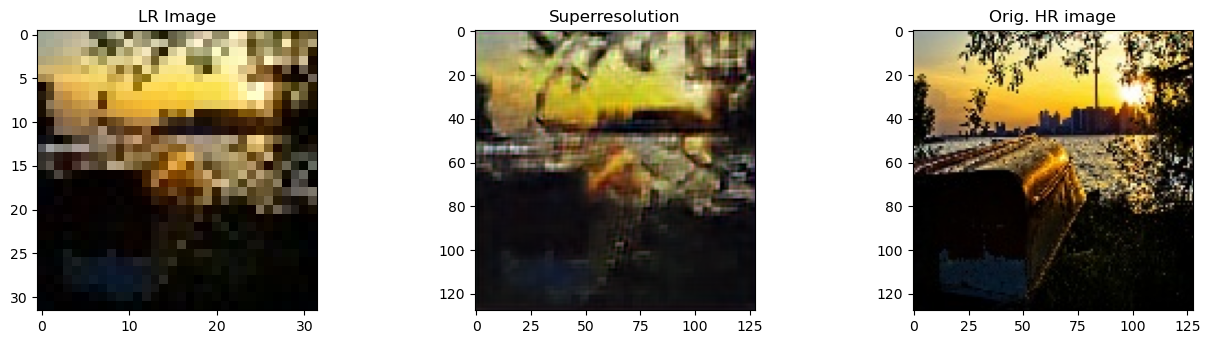

In [12]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [13]:
# Load LR and HR images
test_lr = cv2.imread("test_img32.jpg")
test_hr = cv2.imread("test_img256.jpg")

# Check if the LR image is loaded successfully
if test_lr is not None:
    print("LR image loaded successfully.")
else:
    print("Failed to load LR image.")

# Check if the HR image is loaded successfully
if test_hr is not None:
    print("HR image loaded successfully.")
else:
    print("Failed to load HR image.")

# Change images from BGR to RGB for plotting
test_lr = cv2.cvtColor(test_lr, cv2.COLOR_BGR2RGB)
test_hr = cv2.cvtColor(test_hr, cv2.COLOR_BGR2RGB)

# Normalize pixel values
test_lr = test_lr / 255.
test_hr = test_hr / 255.

# Expand dimensions
test_lr = np.expand_dims(test_lr, axis=0)
test_hr = np.expand_dims(test_hr, axis=0)

# Generate super-resolution image
generated_test_hr = generator.predict(test_lr)


LR image loaded successfully.
HR image loaded successfully.
1/1 [==============================] - 0s 156ms/step


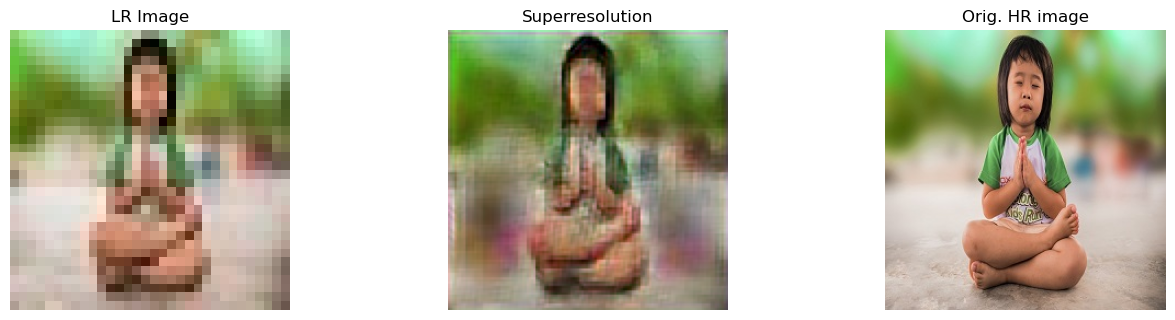

In [14]:
import matplotlib.pyplot as plt

# Plot all three images
plt.figure(figsize=(16, 8))

# LR Image
plt.subplot(231)
plt.title('LR Image')
plt.imshow(test_lr[0,:,:,:].clip(0, 1))  # Clip pixel values to [0, 1] range
plt.axis('off')  # Turn off axis

# Superresolution
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_test_hr[0,:,:,:].clip(0, 1))  # Clip pixel values to [0, 1] range
plt.axis('off')  # Turn off axis

# Original HR image
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(test_hr[0,:,:,:].clip(0, 1))  # Clip pixel values to [0, 1] range
plt.axis('off')  # Turn off axis

plt.show()
